In [1]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer

# Tic Toc Toe environment

Our 1st game is the famous Tic Toc Toe. You can read about the game and its rules here: https://en.wikipedia.org/wiki/Tic-tac-toe

We implemented the game as an environment in the style of games in the [Python GYM library](https://gym.openai.com/). The commented source code is available in the file "tic_env.py". Here, we give a brief introduction to the environment and how it can be used.

### Initialization and attributes

You can initialize the environment / game as following:

In [2]:
env = TictactoeEnv()

Which then has the following attributes with the corresponding initial values:

In [3]:
env.__dict__

{'grid': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'end': False,
 'winner': None,
 'player2value': {'X': 1, 'O': -1},
 'num_step': 0,
 'current_player': 'X'}

The game is played by two players: player 'X' and player 'O'. The attribute 'current_player' shows whose turn it is. We assume that player 'X' always plays first.

The attribute 'grid' is a 3x3 numpy array and presents the board in the real game and the state $s_t$ in the reinfocement learning language. Each elements can take a value in {0, 1, -1}:
     0 : place unmarked
     1 : place marked with X 
    -1 : place marked with O 
        
The attribute 'end' shows if the game is over or not, and the attribute 'winner' shows the winner of the game: either "X", "O", or None.  

You can use function 'render' to visualize the current position of the board:

In [5]:
env.render()

|- - -|
|- - -|
|- - -|



### Taking actions

The game environment will recieve action from two players in turn and update the grid. At each time, one player can take the action $a_t$, where $a_t$ can either be an integer between 0 to 8 or a touple, corresponding to the 9 possible.

Function 'step' is used to recieve the action of the player, update the grid:

In [68]:
env.step(6)

(array([[0., 0., 0.],
        [0., 0., 0.],
        [1., 0., 0.]]),
 False,
 None)

In [19]:
env.render()

|- - O|
|- O X|
|X X O|



In [8]:
env.__dict__

{'grid': array([[0., 0., 1.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'end': False,
 'winner': None,
 'player2value': {'X': 1, 'O': -1},
 'num_step': 1,
 'current_player': 'O'}

In [9]:
env.step((1,1))

(array([[ 0.,  0.,  1.],
        [ 0., -1.,  0.],
        [ 0.,  0.,  0.]]),
 False,
 None)

In [10]:
env.render()

|- - X|
|- O -|
|- - -|



In [11]:
env.__dict__

{'grid': array([[ 0.,  0.,  1.],
        [ 0., -1.,  0.],
        [ 0.,  0.,  0.]]),
 'end': False,
 'winner': None,
 'player2value': {'X': 1, 'O': -1},
 'num_step': 2,
 'current_player': 'X'}

But not all actions are available at each time: One cannot choose a place which has been taken before. There is an error if an unavailable action is taken:

In [73]:
env.step((0,2))

ValueError: There is already a chess on position (0, 2).

### Reward

Reward is always 0 until the end of the game. When the game is over, the reward is 1 if you win the game, -1 if you lose, and 0 besides. Function 'observe' can be used after each step to recieve the new state $s_t$, whether the game is over, and the winner, and function 'reward' to get the reward value $r_t$:

In [12]:
env.observe()

(array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 1.]]),
 False,
 None)

In [14]:
env.reward(player='X')

0

In [15]:
env.reward(player='O')

0

An example of finishing the game:

In [16]:
env.step(0)
env.step(3)
env.step(1)

(array([[ 1.,  1.,  1.],
        [-1., -1.,  0.],
        [ 0.,  0.,  0.]]),
 True,
 'X')

In [17]:
env.render()

|X X X|
|O O -|
|- - -|



In [18]:
env.observe()

(array([[ 1.,  1.,  1.],
        [-1., -1.,  0.],
        [ 0.,  0.,  0.]]),
 True,
 'X')

In [19]:
env.reward(player='X')

1

In [20]:
env.reward(player='O')

-1

# Optimal policy for Tic Toc Toe environment

Fortunately, we know the exact optimal policy for Tic Toc Toe. We have implemented and $\epsilon$-greedy version of optimal polciy which you can use for the project.

In [21]:
env.reset();

In [14]:
opt_player = OptimalPlayer(epsilon = 0., player = 'X')

In [23]:
opt_player.act(env.grid)

(2, 0)

In [24]:
opt_player.player

'X'

### An example of optimal player playing against random player

In [2]:
Turns = np.array(['X','O'])
for i in range(5):
    env.reset()
    grid, _, __ = env.observe()
    Turns = Turns[np.random.permutation(2)]
    player_opt = OptimalPlayer(epsilon=0., player=Turns[0])
    player_rnd = OptimalPlayer(epsilon=1., player=Turns[1])
    for j in range(9):
        if env.current_player == player_opt.player:
            move = player_opt.act(grid)
        else:
            move = player_rnd.act(grid)

        grid, end, winner = env.step(move, print_grid=False)

        if end:
            print('-------------------------------------------')
            print('Game end, winner is player ' + str(winner))
            print('Optimal player = ' +  Turns[0])
            print('Random player = ' +  Turns[1])
            env.render()
            env.reset()
            break


-------------------------------------------
Game end, winner is player X
Optimal player = X
Random player = O
|O - X|
|- X O|
|X - -|

-------------------------------------------
Game end, winner is player X
Optimal player = X
Random player = O
|X O -|
|- X O|
|- - X|

-------------------------------------------
Game end, winner is player X
Optimal player = X
Random player = O
|O - O|
|- X O|
|X X X|

-------------------------------------------
Game end, winner is player O
Optimal player = O
Random player = X
|X - O|
|- O X|
|O - X|

-------------------------------------------
Game end, winner is player None
Optimal player = O
Random player = X
|O X O|
|X O X|
|X O X|



### An example of optimal player playing against optimal player

In [1]:
Turns = np.array(['X','O'])
for i in range(5):
    env.reset()
    grid, _, __ = env.observe()
    Turns = Turns[np.random.permutation(2)]
    player_opt_1 = OptimalPlayer(epsilon=0., player=Turns[0])
    player_opt_2 = OptimalPlayer(epsilon=0., player=Turns[1])
    for j in range(9):
        if env.current_player == player_opt.player:
            move = player_opt_1.act(grid)
        else:
            move = player_opt_2.act(grid)

        grid, end, winner = env.step(move, print_grid=False)

        if end:
            print('-------------------------------------------')
            print('Game end, winner is player ' + str(winner))
            print('Optimal player 1 = ' +  Turns[0])
            print('Optimal player 2 = ' +  Turns[1])
            env.render()
            env.reset()
            break


NameError: name 'np' is not defined

### Q-Learning algorithm

In [2]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
env = TictactoeEnv()

from collections import defaultdict
import random
class Q_Player:
    '''
    Description:
        A class to implement a Q-Learning optimal player in Tic-tac-toe.

    Parameters:
        epsilon: float, in [0, 1]. This is a value between 0-1 that indicates the
            probability of making a random action instead of the optimal action
            at any given time.
        alpha: float, in [0, 1]. This is the learning rate
        gamma: float, in [0, 1]. This is the discount factor

    '''
    def __init__(self, epsilon=0.2, player='X'):
        self.epsilon = epsilon
        self.player = player # 'x' or 'O'
#         self.qvals = qvals # q values for each state
#         self.assignment = assignment # id to label different grids

    def set_player(self, player = 'X', j=-1):
        self.player = player
        if j != -1:
            self.player = 'X' if j % 2 == 0 else 'O'

    def empty(self, grid):
        '''return all empty positions'''
        avail = []
        for i in range(9):
            pos = (int(i/3), i % 3)
            if grid[pos] == 0:
                avail.append(pos)
        return avail
    
    def eps_greedyMove(self, grid, assignment, qvals, val = None):
        """ Return the move with the optimal Q-value according to a epsilon-greedy policy. """
        self.qvals = qvals
        self.assignment = assignment
        grid_id = self.assignment[str(grid)]
        positions = np.full(9, True)
        if val is None:
            val = 1 if self.player == 'X' else -1
        for pos in self.empty(grid):
            grid_ = np.copy(grid)
            grid_[pos] = val            
            action = convert(pos)
            positions[action] = False
#             next_grid_id = self.assignment[str(grid_)]
#             if next_grid_id not in self.neighbours:
#                 self.neighbours[grid_id].append(next_grid_id)
        self.qvals[grid_id][positions] = np.nan
        best_move = int(np.nanargmax(self.qvals[grid_id]))
        if random.random() < self.epsilon:
            move = self.randomMove(grid)
            return move
        else:
            return best_move
        
    def return_dicts(self):
        return self.assignment, self.qvals

    def randomMove(self, grid):
        """ Chose a random move from the available options. """
        avail = self.empty(grid)
        return avail[random.randint(0, len(avail)-1)]

    def act(self, grid, assignment, qvals, **kwargs):
        """
        Goes through a hierarchy of moves, making the best move that
        is currently available each time (with probabitity 1-self.epsilon).
        A touple is returned that represents (row, col).
        """
        return self.eps_greedyMove(grid, assignment, qvals)

In [3]:
def convert(move):
    """
    Convert a move in the tuple format to the int format
    """
    if type(move) != tuple:
        return move
    else:
        return (move[0]*3 + move[1] % 3)

## Q1 & Q2

In [4]:
results = []

for k in range(10):
    Turns = np.array(['X','O'])
    n_games = 20000
    winners = []
    count = []
    qvals = defaultdict(lambda: np.zeros(9))  
    assignments = defaultdict(lambda: len(assignments))
    alpha = 0.05
    gamma = 0.99
    max_eps = 0.8
    min_eps = 0.1
    n_star = 20000
    for i in range(n_games):
        eps = max(min_eps, max_eps*(1-((i+1)/n_star)))
        print(k,i)
        env.reset()
        grid, _, __ = env.observe()
        player_opt_1 = OptimalPlayer(epsilon=0.5, player=Turns[i%2])
        player_q = Q_Player(epsilon=eps, player=Turns[1 - i%2])
        for j in range(9):
            if env.current_player == player_opt_1.player:
                move = player_opt_1.act(grid)
                grid, end, winner = env.step(move, print_grid=False)
                
            else:
                move = player_q.act(grid, assignments, qvals)
                assignments, qvals = player_q.return_dicts()
                last_move_q = convert(move)
                last_grid_q = assignments[str(grid)]
                grid, end, winner = env.step(move, print_grid=False)

            if (env.current_player == player_q.player and j!=0) or end:
                qvals[last_grid_q][last_move_q] += alpha*(env.reward(player=Turns[1 - i%2]) + gamma*np.nanmax(qvals[assignments[str(grid)]]) - qvals[last_grid_q][last_move_q])
            if end:
                winners.append(winner)
                count.append(env.reward(player=Turns[1 - i%2]))
#                 if winner == player_q.player:
#                     count.append(1)
#                 else:
#                     count.append(0)
                env.reset()
#                 print(qvals)
                break
    results.append(count)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
0 149
0 150
0 151
0 152
0 153
0 154
0 155
0 156
0 157
0 158
0 159
0 160
0 161
0 162
0 163
0 164
0 165
0 166
0 167
0 168
0 169
0 170
0 171
0 172
0 173
0 174
0 175
0 176
0 177
0 178
0 179
0 180
0 181
0 182
0 183
0 184


0 1353
0 1354
0 1355
0 1356
0 1357
0 1358
0 1359
0 1360
0 1361
0 1362
0 1363
0 1364
0 1365
0 1366
0 1367
0 1368
0 1369
0 1370
0 1371
0 1372
0 1373
0 1374
0 1375
0 1376
0 1377
0 1378
0 1379
0 1380
0 1381
0 1382
0 1383
0 1384
0 1385
0 1386
0 1387
0 1388
0 1389
0 1390
0 1391
0 1392
0 1393
0 1394
0 1395
0 1396
0 1397
0 1398
0 1399
0 1400
0 1401
0 1402
0 1403
0 1404
0 1405
0 1406
0 1407
0 1408
0 1409
0 1410
0 1411
0 1412
0 1413
0 1414
0 1415
0 1416
0 1417
0 1418
0 1419
0 1420
0 1421
0 1422
0 1423
0 1424
0 1425
0 1426
0 1427
0 1428
0 1429
0 1430
0 1431
0 1432
0 1433
0 1434
0 1435
0 1436
0 1437
0 1438
0 1439
0 1440
0 1441
0 1442
0 1443
0 1444
0 1445
0 1446
0 1447
0 1448
0 1449
0 1450
0 1451
0 1452
0 1453
0 1454
0 1455
0 1456
0 1457
0 1458
0 1459
0 1460
0 1461
0 1462
0 1463
0 1464
0 1465
0 1466
0 1467
0 1468
0 1469
0 1470
0 1471
0 1472
0 1473
0 1474
0 1475
0 1476
0 1477
0 1478
0 1479
0 1480
0 1481
0 1482
0 1483
0 1484
0 1485
0 1486
0 1487
0 1488
0 1489
0 1490
0 1491
0 1492
0 1493
0 1494
0 1495

0 2548
0 2549
0 2550
0 2551
0 2552
0 2553
0 2554
0 2555
0 2556
0 2557
0 2558
0 2559
0 2560
0 2561
0 2562
0 2563
0 2564
0 2565
0 2566
0 2567
0 2568
0 2569
0 2570
0 2571
0 2572
0 2573
0 2574
0 2575
0 2576
0 2577
0 2578
0 2579
0 2580
0 2581
0 2582
0 2583
0 2584
0 2585
0 2586
0 2587
0 2588
0 2589
0 2590
0 2591
0 2592
0 2593
0 2594
0 2595
0 2596
0 2597
0 2598
0 2599
0 2600
0 2601
0 2602
0 2603
0 2604
0 2605
0 2606
0 2607
0 2608
0 2609
0 2610
0 2611
0 2612
0 2613
0 2614
0 2615
0 2616
0 2617
0 2618
0 2619
0 2620
0 2621
0 2622
0 2623
0 2624
0 2625
0 2626
0 2627
0 2628
0 2629
0 2630
0 2631
0 2632
0 2633
0 2634
0 2635
0 2636
0 2637
0 2638
0 2639
0 2640
0 2641
0 2642
0 2643
0 2644
0 2645
0 2646
0 2647
0 2648
0 2649
0 2650
0 2651
0 2652
0 2653
0 2654
0 2655
0 2656
0 2657
0 2658
0 2659
0 2660
0 2661
0 2662
0 2663
0 2664
0 2665
0 2666
0 2667
0 2668
0 2669
0 2670
0 2671
0 2672
0 2673
0 2674
0 2675
0 2676
0 2677
0 2678
0 2679
0 2680
0 2681
0 2682
0 2683
0 2684
0 2685
0 2686
0 2687
0 2688
0 2689
0 2690

0 3731
0 3732
0 3733
0 3734
0 3735
0 3736
0 3737
0 3738
0 3739
0 3740
0 3741
0 3742
0 3743
0 3744
0 3745
0 3746
0 3747
0 3748
0 3749
0 3750
0 3751
0 3752
0 3753
0 3754
0 3755
0 3756
0 3757
0 3758
0 3759
0 3760
0 3761
0 3762
0 3763
0 3764
0 3765
0 3766
0 3767
0 3768
0 3769
0 3770
0 3771
0 3772
0 3773
0 3774
0 3775
0 3776
0 3777
0 3778
0 3779
0 3780
0 3781
0 3782
0 3783
0 3784
0 3785
0 3786
0 3787
0 3788
0 3789
0 3790
0 3791
0 3792
0 3793
0 3794
0 3795
0 3796
0 3797
0 3798
0 3799
0 3800
0 3801
0 3802
0 3803
0 3804
0 3805
0 3806
0 3807
0 3808
0 3809
0 3810
0 3811
0 3812
0 3813
0 3814
0 3815
0 3816
0 3817
0 3818
0 3819
0 3820
0 3821
0 3822
0 3823
0 3824
0 3825
0 3826
0 3827
0 3828
0 3829
0 3830
0 3831
0 3832
0 3833
0 3834
0 3835
0 3836
0 3837
0 3838
0 3839
0 3840
0 3841
0 3842
0 3843
0 3844
0 3845
0 3846
0 3847
0 3848
0 3849
0 3850
0 3851
0 3852
0 3853
0 3854
0 3855
0 3856
0 3857
0 3858
0 3859
0 3860
0 3861
0 3862
0 3863
0 3864
0 3865
0 3866
0 3867
0 3868
0 3869
0 3870
0 3871
0 3872
0 3873

0 4916
0 4917
0 4918
0 4919
0 4920
0 4921
0 4922
0 4923
0 4924
0 4925
0 4926
0 4927
0 4928
0 4929
0 4930
0 4931
0 4932
0 4933
0 4934
0 4935
0 4936
0 4937
0 4938
0 4939
0 4940
0 4941
0 4942
0 4943
0 4944
0 4945
0 4946
0 4947
0 4948
0 4949
0 4950
0 4951
0 4952
0 4953
0 4954
0 4955
0 4956
0 4957
0 4958
0 4959
0 4960
0 4961
0 4962
0 4963
0 4964
0 4965
0 4966
0 4967
0 4968
0 4969
0 4970
0 4971
0 4972
0 4973
0 4974
0 4975
0 4976
0 4977
0 4978
0 4979
0 4980
0 4981
0 4982
0 4983
0 4984
0 4985
0 4986
0 4987
0 4988
0 4989
0 4990
0 4991
0 4992
0 4993
0 4994
0 4995
0 4996
0 4997
0 4998
0 4999
0 5000
0 5001
0 5002
0 5003
0 5004
0 5005
0 5006
0 5007
0 5008
0 5009
0 5010
0 5011
0 5012
0 5013
0 5014
0 5015
0 5016
0 5017
0 5018
0 5019
0 5020
0 5021
0 5022
0 5023
0 5024
0 5025
0 5026
0 5027
0 5028
0 5029
0 5030
0 5031
0 5032
0 5033
0 5034
0 5035
0 5036
0 5037
0 5038
0 5039
0 5040
0 5041
0 5042
0 5043
0 5044
0 5045
0 5046
0 5047
0 5048
0 5049
0 5050
0 5051
0 5052
0 5053
0 5054
0 5055
0 5056
0 5057
0 5058

0 6095
0 6096
0 6097
0 6098
0 6099
0 6100
0 6101
0 6102
0 6103
0 6104
0 6105
0 6106
0 6107
0 6108
0 6109
0 6110
0 6111
0 6112
0 6113
0 6114
0 6115
0 6116
0 6117
0 6118
0 6119
0 6120
0 6121
0 6122
0 6123
0 6124
0 6125
0 6126
0 6127
0 6128
0 6129
0 6130
0 6131
0 6132
0 6133
0 6134
0 6135
0 6136
0 6137
0 6138
0 6139
0 6140
0 6141
0 6142
0 6143
0 6144
0 6145
0 6146
0 6147
0 6148
0 6149
0 6150
0 6151
0 6152
0 6153
0 6154
0 6155
0 6156
0 6157
0 6158
0 6159
0 6160
0 6161
0 6162
0 6163
0 6164
0 6165
0 6166
0 6167
0 6168
0 6169
0 6170
0 6171
0 6172
0 6173
0 6174
0 6175
0 6176
0 6177
0 6178
0 6179
0 6180
0 6181
0 6182
0 6183
0 6184
0 6185
0 6186
0 6187
0 6188
0 6189
0 6190
0 6191
0 6192
0 6193
0 6194
0 6195
0 6196
0 6197
0 6198
0 6199
0 6200
0 6201
0 6202
0 6203
0 6204
0 6205
0 6206
0 6207
0 6208
0 6209
0 6210
0 6211
0 6212
0 6213
0 6214
0 6215
0 6216
0 6217
0 6218
0 6219
0 6220
0 6221
0 6222
0 6223
0 6224
0 6225
0 6226
0 6227
0 6228
0 6229
0 6230
0 6231
0 6232
0 6233
0 6234
0 6235
0 6236
0 6237

0 7273
0 7274
0 7275
0 7276
0 7277
0 7278
0 7279
0 7280
0 7281
0 7282
0 7283
0 7284
0 7285
0 7286
0 7287
0 7288
0 7289
0 7290
0 7291
0 7292
0 7293
0 7294
0 7295
0 7296
0 7297
0 7298
0 7299
0 7300
0 7301
0 7302
0 7303
0 7304
0 7305
0 7306
0 7307
0 7308
0 7309
0 7310
0 7311
0 7312
0 7313
0 7314
0 7315
0 7316
0 7317
0 7318
0 7319
0 7320
0 7321
0 7322
0 7323
0 7324
0 7325
0 7326
0 7327
0 7328
0 7329
0 7330
0 7331
0 7332
0 7333
0 7334
0 7335
0 7336
0 7337
0 7338
0 7339
0 7340
0 7341
0 7342
0 7343
0 7344
0 7345
0 7346
0 7347
0 7348
0 7349
0 7350
0 7351
0 7352
0 7353
0 7354
0 7355
0 7356
0 7357
0 7358
0 7359
0 7360
0 7361
0 7362
0 7363
0 7364
0 7365
0 7366
0 7367
0 7368
0 7369
0 7370
0 7371
0 7372
0 7373
0 7374
0 7375
0 7376
0 7377
0 7378
0 7379
0 7380
0 7381
0 7382
0 7383
0 7384
0 7385
0 7386
0 7387
0 7388
0 7389
0 7390
0 7391
0 7392
0 7393
0 7394
0 7395
0 7396
0 7397
0 7398
0 7399
0 7400
0 7401
0 7402
0 7403
0 7404
0 7405
0 7406
0 7407
0 7408
0 7409
0 7410
0 7411
0 7412
0 7413
0 7414
0 7415

0 8465
0 8466
0 8467
0 8468
0 8469
0 8470
0 8471
0 8472
0 8473
0 8474
0 8475
0 8476
0 8477
0 8478
0 8479
0 8480
0 8481
0 8482
0 8483
0 8484
0 8485
0 8486
0 8487
0 8488
0 8489
0 8490
0 8491
0 8492
0 8493
0 8494
0 8495
0 8496
0 8497
0 8498
0 8499
0 8500
0 8501
0 8502
0 8503
0 8504
0 8505
0 8506
0 8507
0 8508
0 8509
0 8510
0 8511
0 8512
0 8513
0 8514
0 8515
0 8516
0 8517
0 8518
0 8519
0 8520
0 8521
0 8522
0 8523
0 8524
0 8525
0 8526
0 8527
0 8528
0 8529
0 8530
0 8531
0 8532
0 8533
0 8534
0 8535
0 8536
0 8537
0 8538
0 8539
0 8540
0 8541
0 8542
0 8543
0 8544
0 8545
0 8546
0 8547
0 8548
0 8549
0 8550
0 8551
0 8552
0 8553
0 8554
0 8555
0 8556
0 8557
0 8558
0 8559
0 8560
0 8561
0 8562
0 8563
0 8564
0 8565
0 8566
0 8567
0 8568
0 8569
0 8570
0 8571
0 8572
0 8573
0 8574
0 8575
0 8576
0 8577
0 8578
0 8579
0 8580
0 8581
0 8582
0 8583
0 8584
0 8585
0 8586
0 8587
0 8588
0 8589
0 8590
0 8591
0 8592
0 8593
0 8594
0 8595
0 8596
0 8597
0 8598
0 8599
0 8600
0 8601
0 8602
0 8603
0 8604
0 8605
0 8606
0 8607

0 9640
0 9641
0 9642
0 9643
0 9644
0 9645
0 9646
0 9647
0 9648
0 9649
0 9650
0 9651
0 9652
0 9653
0 9654
0 9655
0 9656
0 9657
0 9658
0 9659
0 9660
0 9661
0 9662
0 9663
0 9664
0 9665
0 9666
0 9667
0 9668
0 9669
0 9670
0 9671
0 9672
0 9673
0 9674
0 9675
0 9676
0 9677
0 9678
0 9679
0 9680
0 9681
0 9682
0 9683
0 9684
0 9685
0 9686
0 9687
0 9688
0 9689
0 9690
0 9691
0 9692
0 9693
0 9694
0 9695
0 9696
0 9697
0 9698
0 9699
0 9700
0 9701
0 9702
0 9703
0 9704
0 9705
0 9706
0 9707
0 9708
0 9709
0 9710
0 9711
0 9712
0 9713
0 9714
0 9715
0 9716
0 9717
0 9718
0 9719
0 9720
0 9721
0 9722
0 9723
0 9724
0 9725
0 9726
0 9727
0 9728
0 9729
0 9730
0 9731
0 9732
0 9733
0 9734
0 9735
0 9736
0 9737
0 9738
0 9739
0 9740
0 9741
0 9742
0 9743
0 9744
0 9745
0 9746
0 9747
0 9748
0 9749
0 9750
0 9751
0 9752
0 9753
0 9754
0 9755
0 9756
0 9757
0 9758
0 9759
0 9760
0 9761
0 9762
0 9763
0 9764
0 9765
0 9766
0 9767
0 9768
0 9769
0 9770
0 9771
0 9772
0 9773
0 9774
0 9775
0 9776
0 9777
0 9778
0 9779
0 9780
0 9781
0 9782

0 10729
0 10730
0 10731
0 10732
0 10733
0 10734
0 10735
0 10736
0 10737
0 10738
0 10739
0 10740
0 10741
0 10742
0 10743
0 10744
0 10745
0 10746
0 10747
0 10748
0 10749
0 10750
0 10751
0 10752
0 10753
0 10754
0 10755
0 10756
0 10757
0 10758
0 10759
0 10760
0 10761
0 10762
0 10763
0 10764
0 10765
0 10766
0 10767
0 10768
0 10769
0 10770
0 10771
0 10772
0 10773
0 10774
0 10775
0 10776
0 10777
0 10778
0 10779
0 10780
0 10781
0 10782
0 10783
0 10784
0 10785
0 10786
0 10787
0 10788
0 10789
0 10790
0 10791
0 10792
0 10793
0 10794
0 10795
0 10796
0 10797
0 10798
0 10799
0 10800
0 10801
0 10802
0 10803
0 10804
0 10805
0 10806
0 10807
0 10808
0 10809
0 10810
0 10811
0 10812
0 10813
0 10814
0 10815
0 10816
0 10817
0 10818
0 10819
0 10820
0 10821
0 10822
0 10823
0 10824
0 10825
0 10826
0 10827
0 10828
0 10829
0 10830
0 10831
0 10832
0 10833
0 10834
0 10835
0 10836
0 10837
0 10838
0 10839
0 10840
0 10841
0 10842
0 10843
0 10844
0 10845
0 10846
0 10847
0 10848
0 10849
0 10850
0 10851
0 10852
0 10853


0 11756
0 11757
0 11758
0 11759
0 11760
0 11761
0 11762
0 11763
0 11764
0 11765
0 11766
0 11767
0 11768
0 11769
0 11770
0 11771
0 11772
0 11773
0 11774
0 11775
0 11776
0 11777
0 11778
0 11779
0 11780
0 11781
0 11782
0 11783
0 11784
0 11785
0 11786
0 11787
0 11788
0 11789
0 11790
0 11791
0 11792
0 11793
0 11794
0 11795
0 11796
0 11797
0 11798
0 11799
0 11800
0 11801
0 11802
0 11803
0 11804
0 11805
0 11806
0 11807
0 11808
0 11809
0 11810
0 11811
0 11812
0 11813
0 11814
0 11815
0 11816
0 11817
0 11818
0 11819
0 11820
0 11821
0 11822
0 11823
0 11824
0 11825
0 11826
0 11827
0 11828
0 11829
0 11830
0 11831
0 11832
0 11833
0 11834
0 11835
0 11836
0 11837
0 11838
0 11839
0 11840
0 11841
0 11842
0 11843
0 11844
0 11845
0 11846
0 11847
0 11848
0 11849
0 11850
0 11851
0 11852
0 11853
0 11854
0 11855
0 11856
0 11857
0 11858
0 11859
0 11860
0 11861
0 11862
0 11863
0 11864
0 11865
0 11866
0 11867
0 11868
0 11869
0 11870
0 11871
0 11872
0 11873
0 11874
0 11875
0 11876
0 11877
0 11878
0 11879
0 11880


0 12811
0 12812
0 12813
0 12814
0 12815
0 12816
0 12817
0 12818
0 12819
0 12820
0 12821
0 12822
0 12823
0 12824
0 12825
0 12826
0 12827
0 12828
0 12829
0 12830
0 12831
0 12832
0 12833
0 12834
0 12835
0 12836
0 12837
0 12838
0 12839
0 12840
0 12841
0 12842
0 12843
0 12844
0 12845
0 12846
0 12847
0 12848
0 12849
0 12850
0 12851
0 12852
0 12853
0 12854
0 12855
0 12856
0 12857
0 12858
0 12859
0 12860
0 12861
0 12862
0 12863
0 12864
0 12865
0 12866
0 12867
0 12868
0 12869
0 12870
0 12871
0 12872
0 12873
0 12874
0 12875
0 12876
0 12877
0 12878
0 12879
0 12880
0 12881
0 12882
0 12883
0 12884
0 12885
0 12886
0 12887
0 12888
0 12889
0 12890
0 12891
0 12892
0 12893
0 12894
0 12895
0 12896
0 12897
0 12898
0 12899
0 12900
0 12901
0 12902
0 12903
0 12904
0 12905
0 12906
0 12907
0 12908
0 12909
0 12910
0 12911
0 12912
0 12913
0 12914
0 12915
0 12916
0 12917
0 12918
0 12919
0 12920
0 12921
0 12922
0 12923
0 12924
0 12925
0 12926
0 12927
0 12928
0 12929
0 12930
0 12931
0 12932
0 12933
0 12934
0 12935


0 13842
0 13843
0 13844
0 13845
0 13846
0 13847
0 13848
0 13849
0 13850
0 13851
0 13852
0 13853
0 13854
0 13855
0 13856
0 13857
0 13858
0 13859
0 13860
0 13861
0 13862
0 13863
0 13864
0 13865
0 13866
0 13867
0 13868
0 13869
0 13870
0 13871
0 13872
0 13873
0 13874
0 13875
0 13876
0 13877
0 13878
0 13879
0 13880
0 13881
0 13882
0 13883
0 13884
0 13885
0 13886
0 13887
0 13888
0 13889
0 13890
0 13891
0 13892
0 13893
0 13894
0 13895
0 13896
0 13897
0 13898
0 13899
0 13900
0 13901
0 13902
0 13903
0 13904
0 13905
0 13906
0 13907
0 13908
0 13909
0 13910
0 13911
0 13912
0 13913
0 13914
0 13915
0 13916
0 13917
0 13918
0 13919
0 13920
0 13921
0 13922
0 13923
0 13924
0 13925
0 13926
0 13927
0 13928
0 13929
0 13930
0 13931
0 13932
0 13933
0 13934
0 13935
0 13936
0 13937
0 13938
0 13939
0 13940
0 13941
0 13942
0 13943
0 13944
0 13945
0 13946
0 13947
0 13948
0 13949
0 13950
0 13951
0 13952
0 13953
0 13954
0 13955
0 13956
0 13957
0 13958
0 13959
0 13960
0 13961
0 13962
0 13963
0 13964
0 13965
0 13966


0 14889
0 14890
0 14891
0 14892
0 14893
0 14894
0 14895
0 14896
0 14897
0 14898
0 14899
0 14900
0 14901
0 14902
0 14903
0 14904
0 14905
0 14906
0 14907
0 14908
0 14909
0 14910
0 14911
0 14912
0 14913
0 14914
0 14915
0 14916
0 14917
0 14918
0 14919
0 14920
0 14921
0 14922
0 14923
0 14924
0 14925
0 14926
0 14927
0 14928
0 14929
0 14930
0 14931
0 14932
0 14933
0 14934
0 14935
0 14936
0 14937
0 14938
0 14939
0 14940
0 14941
0 14942
0 14943
0 14944
0 14945
0 14946
0 14947
0 14948
0 14949
0 14950
0 14951
0 14952
0 14953
0 14954
0 14955
0 14956
0 14957
0 14958
0 14959
0 14960
0 14961
0 14962
0 14963
0 14964
0 14965
0 14966
0 14967
0 14968
0 14969
0 14970
0 14971
0 14972
0 14973
0 14974
0 14975
0 14976
0 14977
0 14978
0 14979
0 14980
0 14981
0 14982
0 14983
0 14984
0 14985
0 14986
0 14987
0 14988
0 14989
0 14990
0 14991
0 14992
0 14993
0 14994
0 14995
0 14996
0 14997
0 14998
0 14999
0 15000
0 15001
0 15002
0 15003
0 15004
0 15005
0 15006
0 15007
0 15008
0 15009
0 15010
0 15011
0 15012
0 15013


0 15940
0 15941
0 15942
0 15943
0 15944
0 15945
0 15946
0 15947
0 15948
0 15949
0 15950
0 15951
0 15952
0 15953
0 15954
0 15955
0 15956
0 15957
0 15958
0 15959
0 15960
0 15961
0 15962
0 15963
0 15964
0 15965
0 15966
0 15967
0 15968
0 15969
0 15970
0 15971
0 15972
0 15973
0 15974
0 15975
0 15976
0 15977
0 15978
0 15979
0 15980
0 15981
0 15982
0 15983
0 15984
0 15985
0 15986
0 15987
0 15988
0 15989
0 15990
0 15991
0 15992
0 15993
0 15994
0 15995
0 15996
0 15997
0 15998
0 15999
0 16000
0 16001
0 16002
0 16003
0 16004
0 16005
0 16006
0 16007
0 16008
0 16009
0 16010
0 16011
0 16012
0 16013
0 16014
0 16015
0 16016
0 16017
0 16018
0 16019
0 16020
0 16021
0 16022
0 16023
0 16024
0 16025
0 16026
0 16027
0 16028
0 16029
0 16030
0 16031
0 16032
0 16033
0 16034
0 16035
0 16036
0 16037
0 16038
0 16039
0 16040
0 16041
0 16042
0 16043
0 16044
0 16045
0 16046
0 16047
0 16048
0 16049
0 16050
0 16051
0 16052
0 16053
0 16054
0 16055
0 16056
0 16057
0 16058
0 16059
0 16060
0 16061
0 16062
0 16063
0 16064


0 16977
0 16978
0 16979
0 16980
0 16981
0 16982
0 16983
0 16984
0 16985
0 16986
0 16987
0 16988
0 16989
0 16990
0 16991
0 16992
0 16993
0 16994
0 16995
0 16996
0 16997
0 16998
0 16999
0 17000
0 17001
0 17002
0 17003
0 17004
0 17005
0 17006
0 17007
0 17008
0 17009
0 17010
0 17011
0 17012
0 17013
0 17014
0 17015
0 17016
0 17017
0 17018
0 17019
0 17020
0 17021
0 17022
0 17023
0 17024
0 17025
0 17026
0 17027
0 17028
0 17029
0 17030
0 17031
0 17032
0 17033
0 17034
0 17035
0 17036
0 17037
0 17038
0 17039
0 17040
0 17041
0 17042
0 17043
0 17044
0 17045
0 17046
0 17047
0 17048
0 17049
0 17050
0 17051
0 17052
0 17053
0 17054
0 17055
0 17056
0 17057
0 17058
0 17059
0 17060
0 17061
0 17062
0 17063
0 17064
0 17065
0 17066
0 17067
0 17068
0 17069
0 17070
0 17071
0 17072
0 17073
0 17074
0 17075
0 17076
0 17077
0 17078
0 17079
0 17080
0 17081
0 17082
0 17083
0 17084
0 17085
0 17086
0 17087
0 17088
0 17089
0 17090
0 17091
0 17092
0 17093
0 17094
0 17095
0 17096
0 17097
0 17098
0 17099
0 17100
0 17101


0 18028
0 18029
0 18030
0 18031
0 18032
0 18033
0 18034
0 18035
0 18036
0 18037
0 18038
0 18039
0 18040
0 18041
0 18042
0 18043
0 18044
0 18045
0 18046
0 18047
0 18048
0 18049
0 18050
0 18051
0 18052
0 18053
0 18054
0 18055
0 18056
0 18057
0 18058
0 18059
0 18060
0 18061
0 18062
0 18063
0 18064
0 18065
0 18066
0 18067
0 18068
0 18069
0 18070
0 18071
0 18072
0 18073
0 18074
0 18075
0 18076
0 18077
0 18078
0 18079
0 18080
0 18081
0 18082
0 18083
0 18084
0 18085
0 18086
0 18087
0 18088
0 18089
0 18090
0 18091
0 18092
0 18093
0 18094
0 18095
0 18096
0 18097
0 18098
0 18099
0 18100
0 18101
0 18102
0 18103
0 18104
0 18105
0 18106
0 18107
0 18108
0 18109
0 18110
0 18111
0 18112
0 18113
0 18114
0 18115
0 18116
0 18117
0 18118
0 18119
0 18120
0 18121
0 18122
0 18123
0 18124
0 18125
0 18126
0 18127
0 18128
0 18129
0 18130
0 18131
0 18132
0 18133
0 18134
0 18135
0 18136
0 18137
0 18138
0 18139
0 18140
0 18141
0 18142
0 18143
0 18144
0 18145
0 18146
0 18147
0 18148
0 18149
0 18150
0 18151
0 18152


0 19063
0 19064
0 19065
0 19066
0 19067
0 19068
0 19069
0 19070
0 19071
0 19072
0 19073
0 19074
0 19075
0 19076
0 19077
0 19078
0 19079
0 19080
0 19081
0 19082
0 19083
0 19084
0 19085
0 19086
0 19087
0 19088
0 19089
0 19090
0 19091
0 19092
0 19093
0 19094
0 19095
0 19096
0 19097
0 19098
0 19099
0 19100
0 19101
0 19102
0 19103
0 19104
0 19105
0 19106
0 19107
0 19108
0 19109
0 19110
0 19111
0 19112
0 19113
0 19114
0 19115
0 19116
0 19117
0 19118
0 19119
0 19120
0 19121
0 19122
0 19123
0 19124
0 19125
0 19126
0 19127
0 19128
0 19129
0 19130
0 19131
0 19132
0 19133
0 19134
0 19135
0 19136
0 19137
0 19138
0 19139
0 19140
0 19141
0 19142
0 19143
0 19144
0 19145
0 19146
0 19147
0 19148
0 19149
0 19150
0 19151
0 19152
0 19153
0 19154
0 19155
0 19156
0 19157
0 19158
0 19159
0 19160
0 19161
0 19162
0 19163
0 19164
0 19165
0 19166
0 19167
0 19168
0 19169
0 19170
0 19171
0 19172
0 19173
0 19174
0 19175
0 19176
0 19177
0 19178
0 19179
0 19180
0 19181
0 19182
0 19183
0 19184
0 19185
0 19186
0 19187


1 162
1 163
1 164
1 165
1 166
1 167
1 168
1 169
1 170
1 171
1 172
1 173
1 174
1 175
1 176
1 177
1 178
1 179
1 180
1 181
1 182
1 183
1 184
1 185
1 186
1 187
1 188
1 189
1 190
1 191
1 192
1 193
1 194
1 195
1 196
1 197
1 198
1 199
1 200
1 201
1 202
1 203
1 204
1 205
1 206
1 207
1 208
1 209
1 210
1 211
1 212
1 213
1 214
1 215
1 216
1 217
1 218
1 219
1 220
1 221
1 222
1 223
1 224
1 225
1 226
1 227
1 228
1 229
1 230
1 231
1 232
1 233
1 234
1 235
1 236
1 237
1 238
1 239
1 240
1 241
1 242
1 243
1 244
1 245
1 246
1 247
1 248
1 249
1 250
1 251
1 252
1 253
1 254
1 255
1 256
1 257
1 258
1 259
1 260
1 261
1 262
1 263
1 264
1 265
1 266
1 267
1 268
1 269
1 270
1 271
1 272
1 273
1 274
1 275
1 276
1 277
1 278
1 279
1 280
1 281
1 282
1 283
1 284
1 285
1 286
1 287
1 288
1 289
1 290
1 291
1 292
1 293
1 294
1 295
1 296
1 297
1 298
1 299
1 300
1 301
1 302
1 303
1 304
1 305
1 306
1 307
1 308
1 309
1 310
1 311
1 312
1 313
1 314
1 315
1 316
1 317
1 318
1 319
1 320
1 321
1 322
1 323
1 324
1 325
1 326
1 327
1 32

1 1459
1 1460
1 1461
1 1462
1 1463
1 1464
1 1465
1 1466
1 1467
1 1468
1 1469
1 1470
1 1471
1 1472
1 1473
1 1474
1 1475
1 1476
1 1477
1 1478
1 1479
1 1480
1 1481
1 1482
1 1483
1 1484
1 1485
1 1486
1 1487
1 1488
1 1489
1 1490
1 1491
1 1492
1 1493
1 1494
1 1495
1 1496
1 1497
1 1498
1 1499
1 1500
1 1501
1 1502
1 1503
1 1504
1 1505
1 1506
1 1507
1 1508
1 1509
1 1510
1 1511
1 1512
1 1513
1 1514
1 1515
1 1516
1 1517
1 1518
1 1519
1 1520
1 1521
1 1522
1 1523
1 1524
1 1525
1 1526
1 1527
1 1528
1 1529
1 1530
1 1531
1 1532
1 1533
1 1534
1 1535
1 1536
1 1537
1 1538
1 1539
1 1540
1 1541
1 1542
1 1543
1 1544
1 1545
1 1546
1 1547
1 1548
1 1549
1 1550
1 1551
1 1552
1 1553
1 1554
1 1555
1 1556
1 1557
1 1558
1 1559
1 1560
1 1561
1 1562
1 1563
1 1564
1 1565
1 1566
1 1567
1 1568
1 1569
1 1570
1 1571
1 1572
1 1573
1 1574
1 1575
1 1576
1 1577
1 1578
1 1579
1 1580
1 1581
1 1582
1 1583
1 1584
1 1585
1 1586
1 1587
1 1588
1 1589
1 1590
1 1591
1 1592
1 1593
1 1594
1 1595
1 1596
1 1597
1 1598
1 1599
1 1600
1 1601

1 2639
1 2640
1 2641
1 2642
1 2643
1 2644
1 2645
1 2646
1 2647
1 2648
1 2649
1 2650
1 2651
1 2652
1 2653
1 2654
1 2655
1 2656
1 2657
1 2658
1 2659
1 2660
1 2661
1 2662
1 2663
1 2664
1 2665
1 2666
1 2667
1 2668
1 2669
1 2670
1 2671
1 2672
1 2673
1 2674
1 2675
1 2676
1 2677
1 2678
1 2679
1 2680
1 2681
1 2682
1 2683
1 2684
1 2685
1 2686
1 2687
1 2688
1 2689
1 2690
1 2691
1 2692
1 2693
1 2694
1 2695
1 2696
1 2697
1 2698
1 2699
1 2700
1 2701
1 2702
1 2703
1 2704
1 2705
1 2706
1 2707
1 2708
1 2709
1 2710
1 2711
1 2712
1 2713
1 2714
1 2715
1 2716
1 2717
1 2718
1 2719
1 2720
1 2721
1 2722
1 2723
1 2724
1 2725
1 2726
1 2727
1 2728
1 2729
1 2730
1 2731
1 2732
1 2733
1 2734
1 2735
1 2736
1 2737
1 2738
1 2739
1 2740
1 2741
1 2742
1 2743
1 2744
1 2745
1 2746
1 2747
1 2748
1 2749
1 2750
1 2751
1 2752
1 2753
1 2754
1 2755
1 2756
1 2757
1 2758
1 2759
1 2760
1 2761
1 2762
1 2763
1 2764
1 2765
1 2766
1 2767
1 2768
1 2769
1 2770
1 2771
1 2772
1 2773
1 2774
1 2775
1 2776
1 2777
1 2778
1 2779
1 2780
1 2781

1 3833
1 3834
1 3835
1 3836
1 3837
1 3838
1 3839
1 3840
1 3841
1 3842
1 3843
1 3844
1 3845
1 3846
1 3847
1 3848
1 3849
1 3850
1 3851
1 3852
1 3853
1 3854
1 3855
1 3856
1 3857
1 3858
1 3859
1 3860
1 3861
1 3862
1 3863
1 3864
1 3865
1 3866
1 3867
1 3868
1 3869
1 3870
1 3871
1 3872
1 3873
1 3874
1 3875
1 3876
1 3877
1 3878
1 3879
1 3880
1 3881
1 3882
1 3883
1 3884
1 3885
1 3886
1 3887
1 3888
1 3889
1 3890
1 3891
1 3892
1 3893
1 3894
1 3895
1 3896
1 3897
1 3898
1 3899
1 3900
1 3901
1 3902
1 3903
1 3904
1 3905
1 3906
1 3907
1 3908
1 3909
1 3910
1 3911
1 3912
1 3913
1 3914
1 3915
1 3916
1 3917
1 3918
1 3919
1 3920
1 3921
1 3922
1 3923
1 3924
1 3925
1 3926
1 3927
1 3928
1 3929
1 3930
1 3931
1 3932
1 3933
1 3934
1 3935
1 3936
1 3937
1 3938
1 3939
1 3940
1 3941
1 3942
1 3943
1 3944
1 3945
1 3946
1 3947
1 3948
1 3949
1 3950
1 3951
1 3952
1 3953
1 3954
1 3955
1 3956
1 3957
1 3958
1 3959
1 3960
1 3961
1 3962
1 3963
1 3964
1 3965
1 3966
1 3967
1 3968
1 3969
1 3970
1 3971
1 3972
1 3973
1 3974
1 3975

1 5019
1 5020
1 5021
1 5022
1 5023
1 5024
1 5025
1 5026
1 5027
1 5028
1 5029
1 5030
1 5031
1 5032
1 5033
1 5034
1 5035
1 5036
1 5037
1 5038
1 5039
1 5040
1 5041
1 5042
1 5043
1 5044
1 5045
1 5046
1 5047
1 5048
1 5049
1 5050
1 5051
1 5052
1 5053
1 5054
1 5055
1 5056
1 5057
1 5058
1 5059
1 5060
1 5061
1 5062
1 5063
1 5064
1 5065
1 5066
1 5067
1 5068
1 5069
1 5070
1 5071
1 5072
1 5073
1 5074
1 5075
1 5076
1 5077
1 5078
1 5079
1 5080
1 5081
1 5082
1 5083
1 5084
1 5085
1 5086
1 5087
1 5088
1 5089
1 5090
1 5091
1 5092
1 5093
1 5094
1 5095
1 5096
1 5097
1 5098
1 5099
1 5100
1 5101
1 5102
1 5103
1 5104
1 5105
1 5106
1 5107
1 5108
1 5109
1 5110
1 5111
1 5112
1 5113
1 5114
1 5115
1 5116
1 5117
1 5118
1 5119
1 5120
1 5121
1 5122
1 5123
1 5124
1 5125
1 5126
1 5127
1 5128
1 5129
1 5130
1 5131
1 5132
1 5133
1 5134
1 5135
1 5136
1 5137
1 5138
1 5139
1 5140
1 5141
1 5142
1 5143
1 5144
1 5145
1 5146
1 5147
1 5148
1 5149
1 5150
1 5151
1 5152
1 5153
1 5154
1 5155
1 5156
1 5157
1 5158
1 5159
1 5160
1 5161

1 6204
1 6205
1 6206
1 6207
1 6208
1 6209
1 6210
1 6211
1 6212
1 6213
1 6214
1 6215
1 6216
1 6217
1 6218
1 6219
1 6220
1 6221
1 6222
1 6223
1 6224
1 6225
1 6226
1 6227
1 6228
1 6229
1 6230
1 6231
1 6232
1 6233
1 6234
1 6235
1 6236
1 6237
1 6238
1 6239
1 6240
1 6241
1 6242
1 6243
1 6244
1 6245
1 6246
1 6247
1 6248
1 6249
1 6250
1 6251
1 6252
1 6253
1 6254
1 6255
1 6256
1 6257
1 6258
1 6259
1 6260
1 6261
1 6262
1 6263
1 6264
1 6265
1 6266
1 6267
1 6268
1 6269
1 6270
1 6271
1 6272
1 6273
1 6274
1 6275
1 6276
1 6277
1 6278
1 6279
1 6280
1 6281
1 6282
1 6283
1 6284
1 6285
1 6286
1 6287
1 6288
1 6289
1 6290
1 6291
1 6292
1 6293
1 6294
1 6295
1 6296
1 6297
1 6298
1 6299
1 6300
1 6301
1 6302
1 6303
1 6304
1 6305
1 6306
1 6307
1 6308
1 6309
1 6310
1 6311
1 6312
1 6313
1 6314
1 6315
1 6316
1 6317
1 6318
1 6319
1 6320
1 6321
1 6322
1 6323
1 6324
1 6325
1 6326
1 6327
1 6328
1 6329
1 6330
1 6331
1 6332
1 6333
1 6334
1 6335
1 6336
1 6337
1 6338
1 6339
1 6340
1 6341
1 6342
1 6343
1 6344
1 6345
1 6346

1 7398
1 7399
1 7400
1 7401
1 7402
1 7403
1 7404
1 7405
1 7406
1 7407
1 7408
1 7409
1 7410
1 7411
1 7412
1 7413
1 7414
1 7415
1 7416
1 7417
1 7418
1 7419
1 7420
1 7421
1 7422
1 7423
1 7424
1 7425
1 7426
1 7427
1 7428
1 7429
1 7430
1 7431
1 7432
1 7433
1 7434
1 7435
1 7436
1 7437
1 7438
1 7439
1 7440
1 7441
1 7442
1 7443
1 7444
1 7445
1 7446
1 7447
1 7448
1 7449
1 7450
1 7451
1 7452
1 7453
1 7454
1 7455
1 7456
1 7457
1 7458
1 7459
1 7460
1 7461
1 7462
1 7463
1 7464
1 7465
1 7466
1 7467
1 7468
1 7469
1 7470
1 7471
1 7472
1 7473
1 7474
1 7475
1 7476
1 7477
1 7478
1 7479
1 7480
1 7481
1 7482
1 7483
1 7484
1 7485
1 7486
1 7487
1 7488
1 7489
1 7490
1 7491
1 7492
1 7493
1 7494
1 7495
1 7496
1 7497
1 7498
1 7499
1 7500
1 7501
1 7502
1 7503
1 7504
1 7505
1 7506
1 7507
1 7508
1 7509
1 7510
1 7511
1 7512
1 7513
1 7514
1 7515
1 7516
1 7517
1 7518
1 7519
1 7520
1 7521
1 7522
1 7523
1 7524
1 7525
1 7526
1 7527
1 7528
1 7529
1 7530
1 7531
1 7532
1 7533
1 7534
1 7535
1 7536
1 7537
1 7538
1 7539
1 7540

1 8595
1 8596
1 8597
1 8598
1 8599
1 8600
1 8601
1 8602
1 8603
1 8604
1 8605
1 8606
1 8607
1 8608
1 8609
1 8610
1 8611
1 8612
1 8613
1 8614
1 8615
1 8616
1 8617
1 8618
1 8619
1 8620
1 8621
1 8622
1 8623
1 8624
1 8625
1 8626
1 8627
1 8628
1 8629
1 8630
1 8631
1 8632
1 8633
1 8634
1 8635
1 8636
1 8637
1 8638
1 8639
1 8640
1 8641
1 8642
1 8643
1 8644
1 8645
1 8646
1 8647
1 8648
1 8649
1 8650
1 8651
1 8652
1 8653
1 8654
1 8655
1 8656
1 8657
1 8658
1 8659
1 8660
1 8661
1 8662
1 8663
1 8664
1 8665
1 8666
1 8667
1 8668
1 8669
1 8670
1 8671
1 8672
1 8673
1 8674
1 8675
1 8676
1 8677
1 8678
1 8679
1 8680
1 8681
1 8682
1 8683
1 8684
1 8685
1 8686
1 8687
1 8688
1 8689
1 8690
1 8691
1 8692
1 8693
1 8694
1 8695
1 8696
1 8697
1 8698
1 8699
1 8700
1 8701
1 8702
1 8703
1 8704
1 8705
1 8706
1 8707
1 8708
1 8709
1 8710
1 8711
1 8712
1 8713
1 8714
1 8715
1 8716
1 8717
1 8718
1 8719
1 8720
1 8721
1 8722
1 8723
1 8724
1 8725
1 8726
1 8727
1 8728
1 8729
1 8730
1 8731
1 8732
1 8733
1 8734
1 8735
1 8736
1 8737

1 9776
1 9777
1 9778
1 9779
1 9780
1 9781
1 9782
1 9783
1 9784
1 9785
1 9786
1 9787
1 9788
1 9789
1 9790
1 9791
1 9792
1 9793
1 9794
1 9795
1 9796
1 9797
1 9798
1 9799
1 9800
1 9801
1 9802
1 9803
1 9804
1 9805
1 9806
1 9807
1 9808
1 9809
1 9810
1 9811
1 9812
1 9813
1 9814
1 9815
1 9816
1 9817
1 9818
1 9819
1 9820
1 9821
1 9822
1 9823
1 9824
1 9825
1 9826
1 9827
1 9828
1 9829
1 9830
1 9831
1 9832
1 9833
1 9834
1 9835
1 9836
1 9837
1 9838
1 9839
1 9840
1 9841
1 9842
1 9843
1 9844
1 9845
1 9846
1 9847
1 9848
1 9849
1 9850
1 9851
1 9852
1 9853
1 9854
1 9855
1 9856
1 9857
1 9858
1 9859
1 9860
1 9861
1 9862
1 9863
1 9864
1 9865
1 9866
1 9867
1 9868
1 9869
1 9870
1 9871
1 9872
1 9873
1 9874
1 9875
1 9876
1 9877
1 9878
1 9879
1 9880
1 9881
1 9882
1 9883
1 9884
1 9885
1 9886
1 9887
1 9888
1 9889
1 9890
1 9891
1 9892
1 9893
1 9894
1 9895
1 9896
1 9897
1 9898
1 9899
1 9900
1 9901
1 9902
1 9903
1 9904
1 9905
1 9906
1 9907
1 9908
1 9909
1 9910
1 9911
1 9912
1 9913
1 9914
1 9915
1 9916
1 9917
1 9918

1 10856
1 10857
1 10858
1 10859
1 10860
1 10861
1 10862
1 10863
1 10864
1 10865
1 10866
1 10867
1 10868
1 10869
1 10870
1 10871
1 10872
1 10873
1 10874
1 10875
1 10876
1 10877
1 10878
1 10879
1 10880
1 10881
1 10882
1 10883
1 10884
1 10885
1 10886
1 10887
1 10888
1 10889
1 10890
1 10891
1 10892
1 10893
1 10894
1 10895
1 10896
1 10897
1 10898
1 10899
1 10900
1 10901
1 10902
1 10903
1 10904
1 10905
1 10906
1 10907
1 10908
1 10909
1 10910
1 10911
1 10912
1 10913
1 10914
1 10915
1 10916
1 10917
1 10918
1 10919
1 10920
1 10921
1 10922
1 10923
1 10924
1 10925
1 10926
1 10927
1 10928
1 10929
1 10930
1 10931
1 10932
1 10933
1 10934
1 10935
1 10936
1 10937
1 10938
1 10939
1 10940
1 10941
1 10942
1 10943
1 10944
1 10945
1 10946
1 10947
1 10948
1 10949
1 10950
1 10951
1 10952
1 10953
1 10954
1 10955
1 10956
1 10957
1 10958
1 10959
1 10960
1 10961
1 10962
1 10963
1 10964
1 10965
1 10966
1 10967
1 10968
1 10969
1 10970
1 10971
1 10972
1 10973
1 10974
1 10975
1 10976
1 10977
1 10978
1 10979
1 10980


1 11893
1 11894
1 11895
1 11896
1 11897
1 11898
1 11899
1 11900
1 11901
1 11902
1 11903
1 11904
1 11905
1 11906
1 11907
1 11908
1 11909
1 11910
1 11911
1 11912
1 11913
1 11914
1 11915
1 11916
1 11917
1 11918
1 11919
1 11920
1 11921
1 11922
1 11923
1 11924
1 11925
1 11926
1 11927
1 11928
1 11929
1 11930
1 11931
1 11932
1 11933
1 11934
1 11935
1 11936
1 11937
1 11938
1 11939
1 11940
1 11941
1 11942
1 11943
1 11944
1 11945
1 11946
1 11947
1 11948
1 11949
1 11950
1 11951
1 11952
1 11953
1 11954
1 11955
1 11956
1 11957
1 11958
1 11959
1 11960
1 11961
1 11962
1 11963
1 11964
1 11965
1 11966
1 11967
1 11968
1 11969
1 11970
1 11971
1 11972
1 11973
1 11974
1 11975
1 11976
1 11977
1 11978
1 11979
1 11980
1 11981
1 11982
1 11983
1 11984
1 11985
1 11986
1 11987
1 11988
1 11989
1 11990
1 11991
1 11992
1 11993
1 11994
1 11995
1 11996
1 11997
1 11998
1 11999
1 12000
1 12001
1 12002
1 12003
1 12004
1 12005
1 12006
1 12007
1 12008
1 12009
1 12010
1 12011
1 12012
1 12013
1 12014
1 12015
1 12016
1 12017


1 12943
1 12944
1 12945
1 12946
1 12947
1 12948
1 12949
1 12950
1 12951
1 12952
1 12953
1 12954
1 12955
1 12956
1 12957
1 12958
1 12959
1 12960
1 12961
1 12962
1 12963
1 12964
1 12965
1 12966
1 12967
1 12968
1 12969
1 12970
1 12971
1 12972
1 12973
1 12974
1 12975
1 12976
1 12977
1 12978
1 12979
1 12980
1 12981
1 12982
1 12983
1 12984
1 12985
1 12986
1 12987
1 12988
1 12989
1 12990
1 12991
1 12992
1 12993
1 12994
1 12995
1 12996
1 12997
1 12998
1 12999
1 13000
1 13001
1 13002
1 13003
1 13004
1 13005
1 13006
1 13007
1 13008
1 13009
1 13010
1 13011
1 13012
1 13013
1 13014
1 13015
1 13016
1 13017
1 13018
1 13019
1 13020
1 13021
1 13022
1 13023
1 13024
1 13025
1 13026
1 13027
1 13028
1 13029
1 13030
1 13031
1 13032
1 13033
1 13034
1 13035
1 13036
1 13037
1 13038
1 13039
1 13040
1 13041
1 13042
1 13043
1 13044
1 13045
1 13046
1 13047
1 13048
1 13049
1 13050
1 13051
1 13052
1 13053
1 13054
1 13055
1 13056
1 13057
1 13058
1 13059
1 13060
1 13061
1 13062
1 13063
1 13064
1 13065
1 13066
1 13067


1 13993
1 13994
1 13995
1 13996
1 13997
1 13998
1 13999
1 14000
1 14001
1 14002
1 14003
1 14004
1 14005
1 14006
1 14007
1 14008
1 14009
1 14010
1 14011
1 14012
1 14013
1 14014
1 14015
1 14016
1 14017
1 14018
1 14019
1 14020
1 14021
1 14022
1 14023
1 14024
1 14025
1 14026
1 14027
1 14028
1 14029
1 14030
1 14031
1 14032
1 14033
1 14034
1 14035
1 14036
1 14037
1 14038
1 14039
1 14040
1 14041
1 14042
1 14043
1 14044
1 14045
1 14046
1 14047
1 14048
1 14049
1 14050
1 14051
1 14052
1 14053
1 14054
1 14055
1 14056
1 14057
1 14058
1 14059
1 14060
1 14061
1 14062
1 14063
1 14064
1 14065
1 14066
1 14067
1 14068
1 14069
1 14070
1 14071
1 14072
1 14073
1 14074
1 14075
1 14076
1 14077
1 14078
1 14079
1 14080
1 14081
1 14082
1 14083
1 14084
1 14085
1 14086
1 14087
1 14088
1 14089
1 14090
1 14091
1 14092
1 14093
1 14094
1 14095
1 14096
1 14097
1 14098
1 14099
1 14100
1 14101
1 14102
1 14103
1 14104
1 14105
1 14106
1 14107
1 14108
1 14109
1 14110
1 14111
1 14112
1 14113
1 14114
1 14115
1 14116
1 14117


1 15027
1 15028
1 15029
1 15030
1 15031
1 15032
1 15033
1 15034
1 15035
1 15036
1 15037
1 15038
1 15039
1 15040
1 15041
1 15042
1 15043
1 15044
1 15045
1 15046
1 15047
1 15048
1 15049
1 15050
1 15051
1 15052
1 15053
1 15054
1 15055
1 15056
1 15057
1 15058
1 15059
1 15060
1 15061
1 15062
1 15063
1 15064
1 15065
1 15066
1 15067
1 15068
1 15069
1 15070
1 15071
1 15072
1 15073
1 15074
1 15075
1 15076
1 15077
1 15078
1 15079
1 15080
1 15081
1 15082
1 15083
1 15084
1 15085
1 15086
1 15087
1 15088
1 15089
1 15090
1 15091
1 15092
1 15093
1 15094
1 15095
1 15096
1 15097
1 15098
1 15099
1 15100
1 15101
1 15102
1 15103
1 15104
1 15105
1 15106
1 15107
1 15108
1 15109
1 15110
1 15111
1 15112
1 15113
1 15114
1 15115
1 15116
1 15117
1 15118
1 15119
1 15120
1 15121
1 15122
1 15123
1 15124
1 15125
1 15126
1 15127
1 15128
1 15129
1 15130
1 15131
1 15132
1 15133
1 15134
1 15135
1 15136
1 15137
1 15138
1 15139
1 15140
1 15141
1 15142
1 15143
1 15144
1 15145
1 15146
1 15147
1 15148
1 15149
1 15150
1 15151


1 16051
1 16052
1 16053
1 16054
1 16055
1 16056
1 16057
1 16058
1 16059
1 16060
1 16061
1 16062
1 16063
1 16064
1 16065
1 16066
1 16067
1 16068
1 16069
1 16070
1 16071
1 16072
1 16073
1 16074
1 16075
1 16076
1 16077
1 16078
1 16079
1 16080
1 16081
1 16082
1 16083
1 16084
1 16085
1 16086
1 16087
1 16088
1 16089
1 16090
1 16091
1 16092
1 16093
1 16094
1 16095
1 16096
1 16097
1 16098
1 16099
1 16100
1 16101
1 16102
1 16103
1 16104
1 16105
1 16106
1 16107
1 16108
1 16109
1 16110
1 16111
1 16112
1 16113
1 16114
1 16115
1 16116
1 16117
1 16118
1 16119
1 16120
1 16121
1 16122
1 16123
1 16124
1 16125
1 16126
1 16127
1 16128
1 16129
1 16130
1 16131
1 16132
1 16133
1 16134
1 16135
1 16136
1 16137
1 16138
1 16139
1 16140
1 16141
1 16142
1 16143
1 16144
1 16145
1 16146
1 16147
1 16148
1 16149
1 16150
1 16151
1 16152
1 16153
1 16154
1 16155
1 16156
1 16157
1 16158
1 16159
1 16160
1 16161
1 16162
1 16163
1 16164
1 16165
1 16166
1 16167
1 16168
1 16169
1 16170
1 16171
1 16172
1 16173
1 16174
1 16175


1 17103
1 17104
1 17105
1 17106
1 17107
1 17108
1 17109
1 17110
1 17111
1 17112
1 17113
1 17114
1 17115
1 17116
1 17117
1 17118
1 17119
1 17120
1 17121
1 17122
1 17123
1 17124
1 17125
1 17126
1 17127
1 17128
1 17129
1 17130
1 17131
1 17132
1 17133
1 17134
1 17135
1 17136
1 17137
1 17138
1 17139
1 17140
1 17141
1 17142
1 17143
1 17144
1 17145
1 17146
1 17147
1 17148
1 17149
1 17150
1 17151
1 17152
1 17153
1 17154
1 17155
1 17156
1 17157
1 17158
1 17159
1 17160
1 17161
1 17162
1 17163
1 17164
1 17165
1 17166
1 17167
1 17168
1 17169
1 17170
1 17171
1 17172
1 17173
1 17174
1 17175
1 17176
1 17177
1 17178
1 17179
1 17180
1 17181
1 17182
1 17183
1 17184
1 17185
1 17186
1 17187
1 17188
1 17189
1 17190
1 17191
1 17192
1 17193
1 17194
1 17195
1 17196
1 17197
1 17198
1 17199
1 17200
1 17201
1 17202
1 17203
1 17204
1 17205
1 17206
1 17207
1 17208
1 17209
1 17210
1 17211
1 17212
1 17213
1 17214
1 17215
1 17216
1 17217
1 17218
1 17219
1 17220
1 17221
1 17222
1 17223
1 17224
1 17225
1 17226
1 17227


1 18131
1 18132
1 18133
1 18134
1 18135
1 18136
1 18137
1 18138
1 18139
1 18140
1 18141
1 18142
1 18143
1 18144
1 18145
1 18146
1 18147
1 18148
1 18149
1 18150
1 18151
1 18152
1 18153
1 18154
1 18155
1 18156
1 18157
1 18158
1 18159
1 18160
1 18161
1 18162
1 18163
1 18164
1 18165
1 18166
1 18167
1 18168
1 18169
1 18170
1 18171
1 18172
1 18173
1 18174
1 18175
1 18176
1 18177
1 18178
1 18179
1 18180
1 18181
1 18182
1 18183
1 18184
1 18185
1 18186
1 18187
1 18188
1 18189
1 18190
1 18191
1 18192
1 18193
1 18194
1 18195
1 18196
1 18197
1 18198
1 18199
1 18200
1 18201
1 18202
1 18203
1 18204
1 18205
1 18206
1 18207
1 18208
1 18209
1 18210
1 18211
1 18212
1 18213
1 18214
1 18215
1 18216
1 18217
1 18218
1 18219
1 18220
1 18221
1 18222
1 18223
1 18224
1 18225
1 18226
1 18227
1 18228
1 18229
1 18230
1 18231
1 18232
1 18233
1 18234
1 18235
1 18236
1 18237
1 18238
1 18239
1 18240
1 18241
1 18242
1 18243
1 18244
1 18245
1 18246
1 18247
1 18248
1 18249
1 18250
1 18251
1 18252
1 18253
1 18254
1 18255


1 19171
1 19172
1 19173
1 19174
1 19175
1 19176
1 19177
1 19178
1 19179
1 19180
1 19181
1 19182
1 19183
1 19184
1 19185
1 19186
1 19187
1 19188
1 19189
1 19190
1 19191
1 19192
1 19193
1 19194
1 19195
1 19196
1 19197
1 19198
1 19199
1 19200
1 19201
1 19202
1 19203
1 19204
1 19205
1 19206
1 19207
1 19208
1 19209
1 19210
1 19211
1 19212
1 19213
1 19214
1 19215
1 19216
1 19217
1 19218
1 19219
1 19220
1 19221
1 19222
1 19223
1 19224
1 19225
1 19226
1 19227
1 19228
1 19229
1 19230
1 19231
1 19232
1 19233
1 19234
1 19235
1 19236
1 19237
1 19238
1 19239
1 19240
1 19241
1 19242
1 19243
1 19244
1 19245
1 19246
1 19247
1 19248
1 19249
1 19250
1 19251
1 19252
1 19253
1 19254
1 19255
1 19256
1 19257
1 19258
1 19259
1 19260
1 19261
1 19262
1 19263
1 19264
1 19265
1 19266
1 19267
1 19268
1 19269
1 19270
1 19271
1 19272
1 19273
1 19274
1 19275
1 19276
1 19277
1 19278
1 19279
1 19280
1 19281
1 19282
1 19283
1 19284
1 19285
1 19286
1 19287
1 19288
1 19289
1 19290
1 19291
1 19292
1 19293
1 19294
1 19295


2 288
2 289
2 290
2 291
2 292
2 293
2 294
2 295
2 296
2 297
2 298
2 299
2 300
2 301
2 302
2 303
2 304
2 305
2 306
2 307
2 308
2 309
2 310
2 311
2 312
2 313
2 314
2 315
2 316
2 317
2 318
2 319
2 320
2 321
2 322
2 323
2 324
2 325
2 326
2 327
2 328
2 329
2 330
2 331
2 332
2 333
2 334
2 335
2 336
2 337
2 338
2 339
2 340
2 341
2 342
2 343
2 344
2 345
2 346
2 347
2 348
2 349
2 350
2 351
2 352
2 353
2 354
2 355
2 356
2 357
2 358
2 359
2 360
2 361
2 362
2 363
2 364
2 365
2 366
2 367
2 368
2 369
2 370
2 371
2 372
2 373
2 374
2 375
2 376
2 377
2 378
2 379
2 380
2 381
2 382
2 383
2 384
2 385
2 386
2 387
2 388
2 389
2 390
2 391
2 392
2 393
2 394
2 395
2 396
2 397
2 398
2 399
2 400
2 401
2 402
2 403
2 404
2 405
2 406
2 407
2 408
2 409
2 410
2 411
2 412
2 413
2 414
2 415
2 416
2 417
2 418
2 419
2 420
2 421
2 422
2 423
2 424
2 425
2 426
2 427
2 428
2 429
2 430
2 431
2 432
2 433
2 434
2 435
2 436
2 437
2 438
2 439
2 440
2 441
2 442
2 443
2 444
2 445
2 446
2 447
2 448
2 449
2 450
2 451
2 452
2 453
2 45

2 1584
2 1585
2 1586
2 1587
2 1588
2 1589
2 1590
2 1591
2 1592
2 1593
2 1594
2 1595
2 1596
2 1597
2 1598
2 1599
2 1600
2 1601
2 1602
2 1603
2 1604
2 1605
2 1606
2 1607
2 1608
2 1609
2 1610
2 1611
2 1612
2 1613
2 1614
2 1615
2 1616
2 1617
2 1618
2 1619
2 1620
2 1621
2 1622
2 1623
2 1624
2 1625
2 1626
2 1627
2 1628
2 1629
2 1630
2 1631
2 1632
2 1633
2 1634
2 1635
2 1636
2 1637
2 1638
2 1639
2 1640
2 1641
2 1642
2 1643
2 1644
2 1645
2 1646
2 1647
2 1648
2 1649
2 1650
2 1651
2 1652
2 1653
2 1654
2 1655
2 1656
2 1657
2 1658
2 1659
2 1660
2 1661
2 1662
2 1663
2 1664
2 1665
2 1666
2 1667
2 1668
2 1669
2 1670
2 1671
2 1672
2 1673
2 1674
2 1675
2 1676
2 1677
2 1678
2 1679
2 1680
2 1681
2 1682
2 1683
2 1684
2 1685
2 1686
2 1687
2 1688
2 1689
2 1690
2 1691
2 1692
2 1693
2 1694
2 1695
2 1696
2 1697
2 1698
2 1699
2 1700
2 1701
2 1702
2 1703
2 1704
2 1705
2 1706
2 1707
2 1708
2 1709
2 1710
2 1711
2 1712
2 1713
2 1714
2 1715
2 1716
2 1717
2 1718
2 1719
2 1720
2 1721
2 1722
2 1723
2 1724
2 1725
2 1726

2 2763
2 2764
2 2765
2 2766
2 2767
2 2768
2 2769
2 2770
2 2771
2 2772
2 2773
2 2774
2 2775
2 2776
2 2777
2 2778
2 2779
2 2780
2 2781
2 2782
2 2783
2 2784
2 2785
2 2786
2 2787
2 2788
2 2789
2 2790
2 2791
2 2792
2 2793
2 2794
2 2795
2 2796
2 2797
2 2798
2 2799
2 2800
2 2801
2 2802
2 2803
2 2804
2 2805
2 2806
2 2807
2 2808
2 2809
2 2810
2 2811
2 2812
2 2813
2 2814
2 2815
2 2816
2 2817
2 2818
2 2819
2 2820
2 2821
2 2822
2 2823
2 2824
2 2825
2 2826
2 2827
2 2828
2 2829
2 2830
2 2831
2 2832
2 2833
2 2834
2 2835
2 2836
2 2837
2 2838
2 2839
2 2840
2 2841
2 2842
2 2843
2 2844
2 2845
2 2846
2 2847
2 2848
2 2849
2 2850
2 2851
2 2852
2 2853
2 2854
2 2855
2 2856
2 2857
2 2858
2 2859
2 2860
2 2861
2 2862
2 2863
2 2864
2 2865
2 2866
2 2867
2 2868
2 2869
2 2870
2 2871
2 2872
2 2873
2 2874
2 2875
2 2876
2 2877
2 2878
2 2879
2 2880
2 2881
2 2882
2 2883
2 2884
2 2885
2 2886
2 2887
2 2888
2 2889
2 2890
2 2891
2 2892
2 2893
2 2894
2 2895
2 2896
2 2897
2 2898
2 2899
2 2900
2 2901
2 2902
2 2903
2 2904
2 2905

2 3953
2 3954
2 3955
2 3956
2 3957
2 3958
2 3959
2 3960
2 3961
2 3962
2 3963
2 3964
2 3965
2 3966
2 3967
2 3968
2 3969
2 3970
2 3971
2 3972
2 3973
2 3974
2 3975
2 3976
2 3977
2 3978
2 3979
2 3980
2 3981
2 3982
2 3983
2 3984
2 3985
2 3986
2 3987
2 3988
2 3989
2 3990
2 3991
2 3992
2 3993
2 3994
2 3995
2 3996
2 3997
2 3998
2 3999
2 4000
2 4001
2 4002
2 4003
2 4004
2 4005
2 4006
2 4007
2 4008
2 4009
2 4010
2 4011
2 4012
2 4013
2 4014
2 4015
2 4016
2 4017
2 4018
2 4019
2 4020
2 4021
2 4022
2 4023
2 4024
2 4025
2 4026
2 4027
2 4028
2 4029
2 4030
2 4031
2 4032
2 4033
2 4034
2 4035
2 4036
2 4037
2 4038
2 4039
2 4040
2 4041
2 4042
2 4043
2 4044
2 4045
2 4046
2 4047
2 4048
2 4049
2 4050
2 4051
2 4052
2 4053
2 4054
2 4055
2 4056
2 4057
2 4058
2 4059
2 4060
2 4061
2 4062
2 4063
2 4064
2 4065
2 4066
2 4067
2 4068
2 4069
2 4070
2 4071
2 4072
2 4073
2 4074
2 4075
2 4076
2 4077
2 4078
2 4079
2 4080
2 4081
2 4082
2 4083
2 4084
2 4085
2 4086
2 4087
2 4088
2 4089
2 4090
2 4091
2 4092
2 4093
2 4094
2 4095

2 5135
2 5136
2 5137
2 5138
2 5139
2 5140
2 5141
2 5142
2 5143
2 5144
2 5145
2 5146
2 5147
2 5148
2 5149
2 5150
2 5151
2 5152
2 5153
2 5154
2 5155
2 5156
2 5157
2 5158
2 5159
2 5160
2 5161
2 5162
2 5163
2 5164
2 5165
2 5166
2 5167
2 5168
2 5169
2 5170
2 5171
2 5172
2 5173
2 5174
2 5175
2 5176
2 5177
2 5178
2 5179
2 5180
2 5181
2 5182
2 5183
2 5184
2 5185
2 5186
2 5187
2 5188
2 5189
2 5190
2 5191
2 5192
2 5193
2 5194
2 5195
2 5196
2 5197
2 5198
2 5199
2 5200
2 5201
2 5202
2 5203
2 5204
2 5205
2 5206
2 5207
2 5208
2 5209
2 5210
2 5211
2 5212
2 5213
2 5214
2 5215
2 5216
2 5217
2 5218
2 5219
2 5220
2 5221
2 5222
2 5223
2 5224
2 5225
2 5226
2 5227
2 5228
2 5229
2 5230
2 5231
2 5232
2 5233
2 5234
2 5235
2 5236
2 5237
2 5238
2 5239
2 5240
2 5241
2 5242
2 5243
2 5244
2 5245
2 5246
2 5247
2 5248
2 5249
2 5250
2 5251
2 5252
2 5253
2 5254
2 5255
2 5256
2 5257
2 5258
2 5259
2 5260
2 5261
2 5262
2 5263
2 5264
2 5265
2 5266
2 5267
2 5268
2 5269
2 5270
2 5271
2 5272
2 5273
2 5274
2 5275
2 5276
2 5277

2 6320
2 6321
2 6322
2 6323
2 6324
2 6325
2 6326
2 6327
2 6328
2 6329
2 6330
2 6331
2 6332
2 6333
2 6334
2 6335
2 6336
2 6337
2 6338
2 6339
2 6340
2 6341
2 6342
2 6343
2 6344
2 6345
2 6346
2 6347
2 6348
2 6349
2 6350
2 6351
2 6352
2 6353
2 6354
2 6355
2 6356
2 6357
2 6358
2 6359
2 6360
2 6361
2 6362
2 6363
2 6364
2 6365
2 6366
2 6367
2 6368
2 6369
2 6370
2 6371
2 6372
2 6373
2 6374
2 6375
2 6376
2 6377
2 6378
2 6379
2 6380
2 6381
2 6382
2 6383
2 6384
2 6385
2 6386
2 6387
2 6388
2 6389
2 6390
2 6391
2 6392
2 6393
2 6394
2 6395
2 6396
2 6397
2 6398
2 6399
2 6400
2 6401
2 6402
2 6403
2 6404
2 6405
2 6406
2 6407
2 6408
2 6409
2 6410
2 6411
2 6412
2 6413
2 6414
2 6415
2 6416
2 6417
2 6418
2 6419
2 6420
2 6421
2 6422
2 6423
2 6424
2 6425
2 6426
2 6427
2 6428
2 6429
2 6430
2 6431
2 6432
2 6433
2 6434
2 6435
2 6436
2 6437
2 6438
2 6439
2 6440
2 6441
2 6442
2 6443
2 6444
2 6445
2 6446
2 6447
2 6448
2 6449
2 6450
2 6451
2 6452
2 6453
2 6454
2 6455
2 6456
2 6457
2 6458
2 6459
2 6460
2 6461
2 6462

2 7510
2 7511
2 7512
2 7513
2 7514
2 7515
2 7516
2 7517
2 7518
2 7519
2 7520
2 7521
2 7522
2 7523
2 7524
2 7525
2 7526
2 7527
2 7528
2 7529
2 7530
2 7531
2 7532
2 7533
2 7534
2 7535
2 7536
2 7537
2 7538
2 7539
2 7540
2 7541
2 7542
2 7543
2 7544
2 7545
2 7546
2 7547
2 7548
2 7549
2 7550
2 7551
2 7552
2 7553
2 7554
2 7555
2 7556
2 7557
2 7558
2 7559
2 7560
2 7561
2 7562
2 7563
2 7564
2 7565
2 7566
2 7567
2 7568
2 7569
2 7570
2 7571
2 7572
2 7573
2 7574
2 7575
2 7576
2 7577
2 7578
2 7579
2 7580
2 7581
2 7582
2 7583
2 7584
2 7585
2 7586
2 7587
2 7588
2 7589
2 7590
2 7591
2 7592
2 7593
2 7594
2 7595
2 7596
2 7597
2 7598
2 7599
2 7600
2 7601
2 7602
2 7603
2 7604
2 7605
2 7606
2 7607
2 7608
2 7609
2 7610
2 7611
2 7612
2 7613
2 7614
2 7615
2 7616
2 7617
2 7618
2 7619
2 7620
2 7621
2 7622
2 7623
2 7624
2 7625
2 7626
2 7627
2 7628
2 7629
2 7630
2 7631
2 7632
2 7633
2 7634
2 7635
2 7636
2 7637
2 7638
2 7639
2 7640
2 7641
2 7642
2 7643
2 7644
2 7645
2 7646
2 7647
2 7648
2 7649
2 7650
2 7651
2 7652

2 8695
2 8696
2 8697
2 8698
2 8699
2 8700
2 8701
2 8702
2 8703
2 8704
2 8705
2 8706
2 8707
2 8708
2 8709
2 8710
2 8711
2 8712
2 8713
2 8714
2 8715
2 8716
2 8717
2 8718
2 8719
2 8720
2 8721
2 8722
2 8723
2 8724
2 8725
2 8726
2 8727
2 8728
2 8729
2 8730
2 8731
2 8732
2 8733
2 8734
2 8735
2 8736
2 8737
2 8738
2 8739
2 8740
2 8741
2 8742
2 8743
2 8744
2 8745
2 8746
2 8747
2 8748
2 8749
2 8750
2 8751
2 8752
2 8753
2 8754
2 8755
2 8756
2 8757
2 8758
2 8759
2 8760
2 8761
2 8762
2 8763
2 8764
2 8765
2 8766
2 8767
2 8768
2 8769
2 8770
2 8771
2 8772
2 8773
2 8774
2 8775
2 8776
2 8777
2 8778
2 8779
2 8780
2 8781
2 8782
2 8783
2 8784
2 8785
2 8786
2 8787
2 8788
2 8789
2 8790
2 8791
2 8792
2 8793
2 8794
2 8795
2 8796
2 8797
2 8798
2 8799
2 8800
2 8801
2 8802
2 8803
2 8804
2 8805
2 8806
2 8807
2 8808
2 8809
2 8810
2 8811
2 8812
2 8813
2 8814
2 8815
2 8816
2 8817
2 8818
2 8819
2 8820
2 8821
2 8822
2 8823
2 8824
2 8825
2 8826
2 8827
2 8828
2 8829
2 8830
2 8831
2 8832
2 8833
2 8834
2 8835
2 8836
2 8837

2 9868
2 9869
2 9870
2 9871
2 9872
2 9873
2 9874
2 9875
2 9876
2 9877
2 9878
2 9879
2 9880
2 9881
2 9882
2 9883
2 9884
2 9885
2 9886
2 9887
2 9888
2 9889
2 9890
2 9891
2 9892
2 9893
2 9894
2 9895
2 9896
2 9897
2 9898
2 9899
2 9900
2 9901
2 9902
2 9903
2 9904
2 9905
2 9906
2 9907
2 9908
2 9909
2 9910
2 9911
2 9912
2 9913
2 9914
2 9915
2 9916
2 9917
2 9918
2 9919
2 9920
2 9921
2 9922
2 9923
2 9924
2 9925
2 9926
2 9927
2 9928
2 9929
2 9930
2 9931
2 9932
2 9933
2 9934
2 9935
2 9936
2 9937
2 9938
2 9939
2 9940
2 9941
2 9942
2 9943
2 9944
2 9945
2 9946
2 9947
2 9948
2 9949
2 9950
2 9951
2 9952
2 9953
2 9954
2 9955
2 9956
2 9957
2 9958
2 9959
2 9960
2 9961
2 9962
2 9963
2 9964
2 9965
2 9966
2 9967
2 9968
2 9969
2 9970
2 9971
2 9972
2 9973
2 9974
2 9975
2 9976
2 9977
2 9978
2 9979
2 9980
2 9981
2 9982
2 9983
2 9984
2 9985
2 9986
2 9987
2 9988
2 9989
2 9990
2 9991
2 9992
2 9993
2 9994
2 9995
2 9996
2 9997
2 9998
2 9999
2 10000
2 10001
2 10002
2 10003
2 10004
2 10005
2 10006
2 10007
2 10008
2 10

2 10914
2 10915
2 10916
2 10917
2 10918
2 10919
2 10920
2 10921
2 10922
2 10923
2 10924
2 10925
2 10926
2 10927
2 10928
2 10929
2 10930
2 10931
2 10932
2 10933
2 10934
2 10935
2 10936
2 10937
2 10938
2 10939
2 10940
2 10941
2 10942
2 10943
2 10944
2 10945
2 10946
2 10947
2 10948
2 10949
2 10950
2 10951
2 10952
2 10953
2 10954
2 10955
2 10956
2 10957
2 10958
2 10959
2 10960
2 10961
2 10962
2 10963
2 10964
2 10965
2 10966
2 10967
2 10968
2 10969
2 10970
2 10971
2 10972
2 10973
2 10974
2 10975
2 10976
2 10977
2 10978
2 10979
2 10980
2 10981
2 10982
2 10983
2 10984
2 10985
2 10986
2 10987
2 10988
2 10989
2 10990
2 10991
2 10992
2 10993
2 10994
2 10995
2 10996
2 10997
2 10998
2 10999
2 11000
2 11001
2 11002
2 11003
2 11004
2 11005
2 11006
2 11007
2 11008
2 11009
2 11010
2 11011
2 11012
2 11013
2 11014
2 11015
2 11016
2 11017
2 11018
2 11019
2 11020
2 11021
2 11022
2 11023
2 11024
2 11025
2 11026
2 11027
2 11028
2 11029
2 11030
2 11031
2 11032
2 11033
2 11034
2 11035
2 11036
2 11037
2 11038


2 11960
2 11961
2 11962
2 11963
2 11964
2 11965
2 11966
2 11967
2 11968
2 11969
2 11970
2 11971
2 11972
2 11973
2 11974
2 11975
2 11976
2 11977
2 11978
2 11979
2 11980
2 11981
2 11982
2 11983
2 11984
2 11985
2 11986
2 11987
2 11988
2 11989
2 11990
2 11991
2 11992
2 11993
2 11994
2 11995
2 11996
2 11997
2 11998
2 11999
2 12000
2 12001
2 12002
2 12003
2 12004
2 12005
2 12006
2 12007
2 12008
2 12009
2 12010
2 12011
2 12012
2 12013
2 12014
2 12015
2 12016
2 12017
2 12018
2 12019
2 12020
2 12021
2 12022
2 12023
2 12024
2 12025
2 12026
2 12027
2 12028
2 12029
2 12030
2 12031
2 12032
2 12033
2 12034
2 12035
2 12036
2 12037
2 12038
2 12039
2 12040
2 12041
2 12042
2 12043
2 12044
2 12045
2 12046
2 12047
2 12048
2 12049
2 12050
2 12051
2 12052
2 12053
2 12054
2 12055
2 12056
2 12057
2 12058
2 12059
2 12060
2 12061
2 12062
2 12063
2 12064
2 12065
2 12066
2 12067
2 12068
2 12069
2 12070
2 12071
2 12072
2 12073
2 12074
2 12075
2 12076
2 12077
2 12078
2 12079
2 12080
2 12081
2 12082
2 12083
2 12084


2 13001
2 13002
2 13003
2 13004
2 13005
2 13006
2 13007
2 13008
2 13009
2 13010
2 13011
2 13012
2 13013
2 13014
2 13015
2 13016
2 13017
2 13018
2 13019
2 13020
2 13021
2 13022
2 13023
2 13024
2 13025
2 13026
2 13027
2 13028
2 13029
2 13030
2 13031
2 13032
2 13033
2 13034
2 13035
2 13036
2 13037
2 13038
2 13039
2 13040
2 13041
2 13042
2 13043
2 13044
2 13045
2 13046
2 13047
2 13048
2 13049
2 13050
2 13051
2 13052
2 13053
2 13054
2 13055
2 13056
2 13057
2 13058
2 13059
2 13060
2 13061
2 13062
2 13063
2 13064
2 13065
2 13066
2 13067
2 13068
2 13069
2 13070
2 13071
2 13072
2 13073
2 13074
2 13075
2 13076
2 13077
2 13078
2 13079
2 13080
2 13081
2 13082
2 13083
2 13084
2 13085
2 13086
2 13087
2 13088
2 13089
2 13090
2 13091
2 13092
2 13093
2 13094
2 13095
2 13096
2 13097
2 13098
2 13099
2 13100
2 13101
2 13102
2 13103
2 13104
2 13105
2 13106
2 13107
2 13108
2 13109
2 13110
2 13111
2 13112
2 13113
2 13114
2 13115
2 13116
2 13117
2 13118
2 13119
2 13120
2 13121
2 13122
2 13123
2 13124
2 13125


2 14038
2 14039
2 14040
2 14041
2 14042
2 14043
2 14044
2 14045
2 14046
2 14047
2 14048
2 14049
2 14050
2 14051
2 14052
2 14053
2 14054
2 14055
2 14056
2 14057
2 14058
2 14059
2 14060
2 14061
2 14062
2 14063
2 14064
2 14065
2 14066
2 14067
2 14068
2 14069
2 14070
2 14071
2 14072
2 14073
2 14074
2 14075
2 14076
2 14077
2 14078
2 14079
2 14080
2 14081
2 14082
2 14083
2 14084
2 14085
2 14086
2 14087
2 14088
2 14089
2 14090
2 14091
2 14092
2 14093
2 14094
2 14095
2 14096
2 14097
2 14098
2 14099
2 14100
2 14101
2 14102
2 14103
2 14104
2 14105
2 14106
2 14107
2 14108
2 14109
2 14110
2 14111
2 14112
2 14113
2 14114
2 14115
2 14116
2 14117
2 14118
2 14119
2 14120
2 14121
2 14122
2 14123
2 14124
2 14125
2 14126
2 14127
2 14128
2 14129
2 14130
2 14131
2 14132
2 14133
2 14134
2 14135
2 14136
2 14137
2 14138
2 14139
2 14140
2 14141
2 14142
2 14143
2 14144
2 14145
2 14146
2 14147
2 14148
2 14149
2 14150
2 14151
2 14152
2 14153
2 14154
2 14155
2 14156
2 14157
2 14158
2 14159
2 14160
2 14161
2 14162


2 15084
2 15085
2 15086
2 15087
2 15088
2 15089
2 15090
2 15091
2 15092
2 15093
2 15094
2 15095
2 15096
2 15097
2 15098
2 15099
2 15100
2 15101
2 15102
2 15103
2 15104
2 15105
2 15106
2 15107
2 15108
2 15109
2 15110
2 15111
2 15112
2 15113
2 15114
2 15115
2 15116
2 15117
2 15118
2 15119
2 15120
2 15121
2 15122
2 15123
2 15124
2 15125
2 15126
2 15127
2 15128
2 15129
2 15130
2 15131
2 15132
2 15133
2 15134
2 15135
2 15136
2 15137
2 15138
2 15139
2 15140
2 15141
2 15142
2 15143
2 15144
2 15145
2 15146
2 15147
2 15148
2 15149
2 15150
2 15151
2 15152
2 15153
2 15154
2 15155
2 15156
2 15157
2 15158
2 15159
2 15160
2 15161
2 15162
2 15163
2 15164
2 15165
2 15166
2 15167
2 15168
2 15169
2 15170
2 15171
2 15172
2 15173
2 15174
2 15175
2 15176
2 15177
2 15178
2 15179
2 15180
2 15181
2 15182
2 15183
2 15184
2 15185
2 15186
2 15187
2 15188
2 15189
2 15190
2 15191
2 15192
2 15193
2 15194
2 15195
2 15196
2 15197
2 15198
2 15199
2 15200
2 15201
2 15202
2 15203
2 15204
2 15205
2 15206
2 15207
2 15208


2 16121
2 16122
2 16123
2 16124
2 16125
2 16126
2 16127
2 16128
2 16129
2 16130
2 16131
2 16132
2 16133
2 16134
2 16135
2 16136
2 16137
2 16138
2 16139
2 16140
2 16141
2 16142
2 16143
2 16144
2 16145
2 16146
2 16147
2 16148
2 16149
2 16150
2 16151
2 16152
2 16153
2 16154
2 16155
2 16156
2 16157
2 16158
2 16159
2 16160
2 16161
2 16162
2 16163
2 16164
2 16165
2 16166
2 16167
2 16168
2 16169
2 16170
2 16171
2 16172
2 16173
2 16174
2 16175
2 16176
2 16177
2 16178
2 16179
2 16180
2 16181
2 16182
2 16183
2 16184
2 16185
2 16186
2 16187
2 16188
2 16189
2 16190
2 16191
2 16192
2 16193
2 16194
2 16195
2 16196
2 16197
2 16198
2 16199
2 16200
2 16201
2 16202
2 16203
2 16204
2 16205
2 16206
2 16207
2 16208
2 16209
2 16210
2 16211
2 16212
2 16213
2 16214
2 16215
2 16216
2 16217
2 16218
2 16219
2 16220
2 16221
2 16222
2 16223
2 16224
2 16225
2 16226
2 16227
2 16228
2 16229
2 16230
2 16231
2 16232
2 16233
2 16234
2 16235
2 16236
2 16237
2 16238
2 16239
2 16240
2 16241
2 16242
2 16243
2 16244
2 16245


2 17156
2 17157
2 17158
2 17159
2 17160
2 17161
2 17162
2 17163
2 17164
2 17165
2 17166
2 17167
2 17168
2 17169
2 17170
2 17171
2 17172
2 17173
2 17174
2 17175
2 17176
2 17177
2 17178
2 17179
2 17180
2 17181
2 17182
2 17183
2 17184
2 17185
2 17186
2 17187
2 17188
2 17189
2 17190
2 17191
2 17192
2 17193
2 17194
2 17195
2 17196
2 17197
2 17198
2 17199
2 17200
2 17201
2 17202
2 17203
2 17204
2 17205
2 17206
2 17207
2 17208
2 17209
2 17210
2 17211
2 17212
2 17213
2 17214
2 17215
2 17216
2 17217
2 17218
2 17219
2 17220
2 17221
2 17222
2 17223
2 17224
2 17225
2 17226
2 17227
2 17228
2 17229
2 17230
2 17231
2 17232
2 17233
2 17234
2 17235
2 17236
2 17237
2 17238
2 17239
2 17240
2 17241
2 17242
2 17243
2 17244
2 17245
2 17246
2 17247
2 17248
2 17249
2 17250
2 17251
2 17252
2 17253
2 17254
2 17255
2 17256
2 17257
2 17258
2 17259
2 17260
2 17261
2 17262
2 17263
2 17264
2 17265
2 17266
2 17267
2 17268
2 17269
2 17270
2 17271
2 17272
2 17273
2 17274
2 17275
2 17276
2 17277
2 17278
2 17279
2 17280


2 18200
2 18201
2 18202
2 18203
2 18204
2 18205
2 18206
2 18207
2 18208
2 18209
2 18210
2 18211
2 18212
2 18213
2 18214
2 18215
2 18216
2 18217
2 18218
2 18219
2 18220
2 18221
2 18222
2 18223
2 18224
2 18225
2 18226
2 18227
2 18228
2 18229
2 18230
2 18231
2 18232
2 18233
2 18234
2 18235
2 18236
2 18237
2 18238
2 18239
2 18240
2 18241
2 18242
2 18243
2 18244
2 18245
2 18246
2 18247
2 18248
2 18249
2 18250
2 18251
2 18252
2 18253
2 18254
2 18255
2 18256
2 18257
2 18258
2 18259
2 18260
2 18261
2 18262
2 18263
2 18264
2 18265
2 18266
2 18267
2 18268
2 18269
2 18270
2 18271
2 18272
2 18273
2 18274
2 18275
2 18276
2 18277
2 18278
2 18279
2 18280
2 18281
2 18282
2 18283
2 18284
2 18285
2 18286
2 18287
2 18288
2 18289
2 18290
2 18291
2 18292
2 18293
2 18294
2 18295
2 18296
2 18297
2 18298
2 18299
2 18300
2 18301
2 18302
2 18303
2 18304
2 18305
2 18306
2 18307
2 18308
2 18309
2 18310
2 18311
2 18312
2 18313
2 18314
2 18315
2 18316
2 18317
2 18318
2 18319
2 18320
2 18321
2 18322
2 18323
2 18324


2 19243
2 19244
2 19245
2 19246
2 19247
2 19248
2 19249
2 19250
2 19251
2 19252
2 19253
2 19254
2 19255
2 19256
2 19257
2 19258
2 19259
2 19260
2 19261
2 19262
2 19263
2 19264
2 19265
2 19266
2 19267
2 19268
2 19269
2 19270
2 19271
2 19272
2 19273
2 19274
2 19275
2 19276
2 19277
2 19278
2 19279
2 19280
2 19281
2 19282
2 19283
2 19284
2 19285
2 19286
2 19287
2 19288
2 19289
2 19290
2 19291
2 19292
2 19293
2 19294
2 19295
2 19296
2 19297
2 19298
2 19299
2 19300
2 19301
2 19302
2 19303
2 19304
2 19305
2 19306
2 19307
2 19308
2 19309
2 19310
2 19311
2 19312
2 19313
2 19314
2 19315
2 19316
2 19317
2 19318
2 19319
2 19320
2 19321
2 19322
2 19323
2 19324
2 19325
2 19326
2 19327
2 19328
2 19329
2 19330
2 19331
2 19332
2 19333
2 19334
2 19335
2 19336
2 19337
2 19338
2 19339
2 19340
2 19341
2 19342
2 19343
2 19344
2 19345
2 19346
2 19347
2 19348
2 19349
2 19350
2 19351
2 19352
2 19353
2 19354
2 19355
2 19356
2 19357
2 19358
2 19359
2 19360
2 19361
2 19362
2 19363
2 19364
2 19365
2 19366
2 19367


3 376
3 377
3 378
3 379
3 380
3 381
3 382
3 383
3 384
3 385
3 386
3 387
3 388
3 389
3 390
3 391
3 392
3 393
3 394
3 395
3 396
3 397
3 398
3 399
3 400
3 401
3 402
3 403
3 404
3 405
3 406
3 407
3 408
3 409
3 410
3 411
3 412
3 413
3 414
3 415
3 416
3 417
3 418
3 419
3 420
3 421
3 422
3 423
3 424
3 425
3 426
3 427
3 428
3 429
3 430
3 431
3 432
3 433
3 434
3 435
3 436
3 437
3 438
3 439
3 440
3 441
3 442
3 443
3 444
3 445
3 446
3 447
3 448
3 449
3 450
3 451
3 452
3 453
3 454
3 455
3 456
3 457
3 458
3 459
3 460
3 461
3 462
3 463
3 464
3 465
3 466
3 467
3 468
3 469
3 470
3 471
3 472
3 473
3 474
3 475
3 476
3 477
3 478
3 479
3 480
3 481
3 482
3 483
3 484
3 485
3 486
3 487
3 488
3 489
3 490
3 491
3 492
3 493
3 494
3 495
3 496
3 497
3 498
3 499
3 500
3 501
3 502
3 503
3 504
3 505
3 506
3 507
3 508
3 509
3 510
3 511
3 512
3 513
3 514
3 515
3 516
3 517
3 518
3 519
3 520
3 521
3 522
3 523
3 524
3 525
3 526
3 527
3 528
3 529
3 530
3 531
3 532
3 533
3 534
3 535
3 536
3 537
3 538
3 539
3 540
3 541
3 54

3 1660
3 1661
3 1662
3 1663
3 1664
3 1665
3 1666
3 1667
3 1668
3 1669
3 1670
3 1671
3 1672
3 1673
3 1674
3 1675
3 1676
3 1677
3 1678
3 1679
3 1680
3 1681
3 1682
3 1683
3 1684
3 1685
3 1686
3 1687
3 1688
3 1689
3 1690
3 1691
3 1692
3 1693
3 1694
3 1695
3 1696
3 1697
3 1698
3 1699
3 1700
3 1701
3 1702
3 1703
3 1704
3 1705
3 1706
3 1707
3 1708
3 1709
3 1710
3 1711
3 1712
3 1713
3 1714
3 1715
3 1716
3 1717
3 1718
3 1719
3 1720
3 1721
3 1722
3 1723
3 1724
3 1725
3 1726
3 1727
3 1728
3 1729
3 1730
3 1731
3 1732
3 1733
3 1734
3 1735
3 1736
3 1737
3 1738
3 1739
3 1740
3 1741
3 1742
3 1743
3 1744
3 1745
3 1746
3 1747
3 1748
3 1749
3 1750
3 1751
3 1752
3 1753
3 1754
3 1755
3 1756
3 1757
3 1758
3 1759
3 1760
3 1761
3 1762
3 1763
3 1764
3 1765
3 1766
3 1767
3 1768
3 1769
3 1770
3 1771
3 1772
3 1773
3 1774
3 1775
3 1776
3 1777
3 1778
3 1779
3 1780
3 1781
3 1782
3 1783
3 1784
3 1785
3 1786
3 1787
3 1788
3 1789
3 1790
3 1791
3 1792
3 1793
3 1794
3 1795
3 1796
3 1797
3 1798
3 1799
3 1800
3 1801
3 1802

3 2832
3 2833
3 2834
3 2835
3 2836
3 2837
3 2838
3 2839
3 2840
3 2841
3 2842
3 2843
3 2844
3 2845
3 2846
3 2847
3 2848
3 2849
3 2850
3 2851
3 2852
3 2853
3 2854
3 2855
3 2856
3 2857
3 2858
3 2859
3 2860
3 2861
3 2862
3 2863
3 2864
3 2865
3 2866
3 2867
3 2868
3 2869
3 2870
3 2871
3 2872
3 2873
3 2874
3 2875
3 2876
3 2877
3 2878
3 2879
3 2880
3 2881
3 2882
3 2883
3 2884
3 2885
3 2886
3 2887
3 2888
3 2889
3 2890
3 2891
3 2892
3 2893
3 2894
3 2895
3 2896
3 2897
3 2898
3 2899
3 2900
3 2901
3 2902
3 2903
3 2904
3 2905
3 2906
3 2907
3 2908
3 2909
3 2910
3 2911
3 2912
3 2913
3 2914
3 2915
3 2916
3 2917
3 2918
3 2919
3 2920
3 2921
3 2922
3 2923
3 2924
3 2925
3 2926
3 2927
3 2928
3 2929
3 2930
3 2931
3 2932
3 2933
3 2934
3 2935
3 2936
3 2937
3 2938
3 2939
3 2940
3 2941
3 2942
3 2943
3 2944
3 2945
3 2946
3 2947
3 2948
3 2949
3 2950
3 2951
3 2952
3 2953
3 2954
3 2955
3 2956
3 2957
3 2958
3 2959
3 2960
3 2961
3 2962
3 2963
3 2964
3 2965
3 2966
3 2967
3 2968
3 2969
3 2970
3 2971
3 2972
3 2973
3 2974

3 4009
3 4010
3 4011
3 4012
3 4013
3 4014
3 4015
3 4016
3 4017
3 4018
3 4019
3 4020
3 4021
3 4022
3 4023
3 4024
3 4025
3 4026
3 4027
3 4028
3 4029
3 4030
3 4031
3 4032
3 4033
3 4034
3 4035
3 4036
3 4037
3 4038
3 4039
3 4040
3 4041
3 4042
3 4043
3 4044
3 4045
3 4046
3 4047
3 4048
3 4049
3 4050
3 4051
3 4052
3 4053
3 4054
3 4055
3 4056
3 4057
3 4058
3 4059
3 4060
3 4061
3 4062
3 4063
3 4064
3 4065
3 4066
3 4067
3 4068
3 4069
3 4070
3 4071
3 4072
3 4073
3 4074
3 4075
3 4076
3 4077
3 4078
3 4079
3 4080
3 4081
3 4082
3 4083
3 4084
3 4085
3 4086
3 4087
3 4088
3 4089
3 4090
3 4091
3 4092
3 4093
3 4094
3 4095
3 4096
3 4097
3 4098
3 4099
3 4100
3 4101
3 4102
3 4103
3 4104
3 4105
3 4106
3 4107
3 4108
3 4109
3 4110
3 4111
3 4112
3 4113
3 4114
3 4115
3 4116
3 4117
3 4118
3 4119
3 4120
3 4121
3 4122
3 4123
3 4124
3 4125
3 4126
3 4127
3 4128
3 4129
3 4130
3 4131
3 4132
3 4133
3 4134
3 4135
3 4136
3 4137
3 4138
3 4139
3 4140
3 4141
3 4142
3 4143
3 4144
3 4145
3 4146
3 4147
3 4148
3 4149
3 4150
3 4151

3 5205
3 5206
3 5207
3 5208
3 5209
3 5210
3 5211
3 5212
3 5213
3 5214
3 5215
3 5216
3 5217
3 5218
3 5219
3 5220
3 5221
3 5222
3 5223
3 5224
3 5225
3 5226
3 5227
3 5228
3 5229
3 5230
3 5231
3 5232
3 5233
3 5234
3 5235
3 5236
3 5237
3 5238
3 5239
3 5240
3 5241
3 5242
3 5243
3 5244
3 5245
3 5246
3 5247
3 5248
3 5249
3 5250
3 5251
3 5252
3 5253
3 5254
3 5255
3 5256
3 5257
3 5258
3 5259
3 5260
3 5261
3 5262
3 5263
3 5264
3 5265
3 5266
3 5267
3 5268
3 5269
3 5270
3 5271
3 5272
3 5273
3 5274
3 5275
3 5276
3 5277
3 5278
3 5279
3 5280
3 5281
3 5282
3 5283
3 5284
3 5285
3 5286
3 5287
3 5288
3 5289
3 5290
3 5291
3 5292
3 5293
3 5294
3 5295
3 5296
3 5297
3 5298
3 5299
3 5300
3 5301
3 5302
3 5303
3 5304
3 5305
3 5306
3 5307
3 5308
3 5309
3 5310
3 5311
3 5312
3 5313
3 5314
3 5315
3 5316
3 5317
3 5318
3 5319
3 5320
3 5321
3 5322
3 5323
3 5324
3 5325
3 5326
3 5327
3 5328
3 5329
3 5330
3 5331
3 5332
3 5333
3 5334
3 5335
3 5336
3 5337
3 5338
3 5339
3 5340
3 5341
3 5342
3 5343
3 5344
3 5345
3 5346
3 5347

3 6384
3 6385
3 6386
3 6387
3 6388
3 6389
3 6390
3 6391
3 6392
3 6393
3 6394
3 6395
3 6396
3 6397
3 6398
3 6399
3 6400
3 6401
3 6402
3 6403
3 6404
3 6405
3 6406
3 6407
3 6408
3 6409
3 6410
3 6411
3 6412
3 6413
3 6414
3 6415
3 6416
3 6417
3 6418
3 6419
3 6420
3 6421
3 6422
3 6423
3 6424
3 6425
3 6426
3 6427
3 6428
3 6429
3 6430
3 6431
3 6432
3 6433
3 6434
3 6435
3 6436
3 6437
3 6438
3 6439
3 6440
3 6441
3 6442
3 6443
3 6444
3 6445
3 6446
3 6447
3 6448
3 6449
3 6450
3 6451
3 6452
3 6453
3 6454
3 6455
3 6456
3 6457
3 6458
3 6459
3 6460
3 6461
3 6462
3 6463
3 6464
3 6465
3 6466
3 6467
3 6468
3 6469
3 6470
3 6471
3 6472
3 6473
3 6474
3 6475
3 6476
3 6477
3 6478
3 6479
3 6480
3 6481
3 6482
3 6483
3 6484
3 6485
3 6486
3 6487
3 6488
3 6489
3 6490
3 6491
3 6492
3 6493
3 6494
3 6495
3 6496
3 6497
3 6498
3 6499
3 6500
3 6501
3 6502
3 6503
3 6504
3 6505
3 6506
3 6507
3 6508
3 6509
3 6510
3 6511
3 6512
3 6513
3 6514
3 6515
3 6516
3 6517
3 6518
3 6519
3 6520
3 6521
3 6522
3 6523
3 6524
3 6525
3 6526

3 7564
3 7565
3 7566
3 7567
3 7568
3 7569
3 7570
3 7571
3 7572
3 7573
3 7574
3 7575
3 7576
3 7577
3 7578
3 7579
3 7580
3 7581
3 7582
3 7583
3 7584
3 7585
3 7586
3 7587
3 7588
3 7589
3 7590
3 7591
3 7592
3 7593
3 7594
3 7595
3 7596
3 7597
3 7598
3 7599
3 7600
3 7601
3 7602
3 7603
3 7604
3 7605
3 7606
3 7607
3 7608
3 7609
3 7610
3 7611
3 7612
3 7613
3 7614
3 7615
3 7616
3 7617
3 7618
3 7619
3 7620
3 7621
3 7622
3 7623
3 7624
3 7625
3 7626
3 7627
3 7628
3 7629
3 7630
3 7631
3 7632
3 7633
3 7634
3 7635
3 7636
3 7637
3 7638
3 7639
3 7640
3 7641
3 7642
3 7643
3 7644
3 7645
3 7646
3 7647
3 7648
3 7649
3 7650
3 7651
3 7652
3 7653
3 7654
3 7655
3 7656
3 7657
3 7658
3 7659
3 7660
3 7661
3 7662
3 7663
3 7664
3 7665
3 7666
3 7667
3 7668
3 7669
3 7670
3 7671
3 7672
3 7673
3 7674
3 7675
3 7676
3 7677
3 7678
3 7679
3 7680
3 7681
3 7682
3 7683
3 7684
3 7685
3 7686
3 7687
3 7688
3 7689
3 7690
3 7691
3 7692
3 7693
3 7694
3 7695
3 7696
3 7697
3 7698
3 7699
3 7700
3 7701
3 7702
3 7703
3 7704
3 7705
3 7706

3 8743
3 8744
3 8745
3 8746
3 8747
3 8748
3 8749
3 8750
3 8751
3 8752
3 8753
3 8754
3 8755
3 8756
3 8757
3 8758
3 8759
3 8760
3 8761
3 8762
3 8763
3 8764
3 8765
3 8766
3 8767
3 8768
3 8769
3 8770
3 8771
3 8772
3 8773
3 8774
3 8775
3 8776
3 8777
3 8778
3 8779
3 8780
3 8781
3 8782
3 8783
3 8784
3 8785
3 8786
3 8787
3 8788
3 8789
3 8790
3 8791
3 8792
3 8793
3 8794
3 8795
3 8796
3 8797
3 8798
3 8799
3 8800
3 8801
3 8802
3 8803
3 8804
3 8805
3 8806
3 8807
3 8808
3 8809
3 8810
3 8811
3 8812
3 8813
3 8814
3 8815
3 8816
3 8817
3 8818
3 8819
3 8820
3 8821
3 8822
3 8823
3 8824
3 8825
3 8826
3 8827
3 8828
3 8829
3 8830
3 8831
3 8832
3 8833
3 8834
3 8835
3 8836
3 8837
3 8838
3 8839
3 8840
3 8841
3 8842
3 8843
3 8844
3 8845
3 8846
3 8847
3 8848
3 8849
3 8850
3 8851
3 8852
3 8853
3 8854
3 8855
3 8856
3 8857
3 8858
3 8859
3 8860
3 8861
3 8862
3 8863
3 8864
3 8865
3 8866
3 8867
3 8868
3 8869
3 8870
3 8871
3 8872
3 8873
3 8874
3 8875
3 8876
3 8877
3 8878
3 8879
3 8880
3 8881
3 8882
3 8883
3 8884
3 8885

3 9915
3 9916
3 9917
3 9918
3 9919
3 9920
3 9921
3 9922
3 9923
3 9924
3 9925
3 9926
3 9927
3 9928
3 9929
3 9930
3 9931
3 9932
3 9933
3 9934
3 9935
3 9936
3 9937
3 9938
3 9939
3 9940
3 9941
3 9942
3 9943
3 9944
3 9945
3 9946
3 9947
3 9948
3 9949
3 9950
3 9951
3 9952
3 9953
3 9954
3 9955
3 9956
3 9957
3 9958
3 9959
3 9960
3 9961
3 9962
3 9963
3 9964
3 9965
3 9966
3 9967
3 9968
3 9969
3 9970
3 9971
3 9972
3 9973
3 9974
3 9975
3 9976
3 9977
3 9978
3 9979
3 9980
3 9981
3 9982
3 9983
3 9984
3 9985
3 9986
3 9987
3 9988
3 9989
3 9990
3 9991
3 9992
3 9993
3 9994
3 9995
3 9996
3 9997
3 9998
3 9999
3 10000
3 10001
3 10002
3 10003
3 10004
3 10005
3 10006
3 10007
3 10008
3 10009
3 10010
3 10011
3 10012
3 10013
3 10014
3 10015
3 10016
3 10017
3 10018
3 10019
3 10020
3 10021
3 10022
3 10023
3 10024
3 10025
3 10026
3 10027
3 10028
3 10029
3 10030
3 10031
3 10032
3 10033
3 10034
3 10035
3 10036
3 10037
3 10038
3 10039
3 10040
3 10041
3 10042
3 10043
3 10044
3 10045
3 10046
3 10047
3 10048
3 10049
3 100

3 10975
3 10976
3 10977
3 10978
3 10979
3 10980
3 10981
3 10982
3 10983
3 10984
3 10985
3 10986
3 10987
3 10988
3 10989
3 10990
3 10991
3 10992
3 10993
3 10994
3 10995
3 10996
3 10997
3 10998
3 10999
3 11000
3 11001
3 11002
3 11003
3 11004
3 11005
3 11006
3 11007
3 11008
3 11009
3 11010
3 11011
3 11012
3 11013
3 11014
3 11015
3 11016
3 11017
3 11018
3 11019
3 11020
3 11021
3 11022
3 11023
3 11024
3 11025
3 11026
3 11027
3 11028
3 11029
3 11030
3 11031
3 11032
3 11033
3 11034
3 11035
3 11036
3 11037
3 11038
3 11039
3 11040
3 11041
3 11042
3 11043
3 11044
3 11045
3 11046
3 11047
3 11048
3 11049
3 11050
3 11051
3 11052
3 11053
3 11054
3 11055
3 11056
3 11057
3 11058
3 11059
3 11060
3 11061
3 11062
3 11063
3 11064
3 11065
3 11066
3 11067
3 11068
3 11069
3 11070
3 11071
3 11072
3 11073
3 11074
3 11075
3 11076
3 11077
3 11078
3 11079
3 11080
3 11081
3 11082
3 11083
3 11084
3 11085
3 11086
3 11087
3 11088
3 11089
3 11090
3 11091
3 11092
3 11093
3 11094
3 11095
3 11096
3 11097
3 11098
3 11099


3 12013
3 12014
3 12015
3 12016
3 12017
3 12018
3 12019
3 12020
3 12021
3 12022
3 12023
3 12024
3 12025
3 12026
3 12027
3 12028
3 12029
3 12030
3 12031
3 12032
3 12033
3 12034
3 12035
3 12036
3 12037
3 12038
3 12039
3 12040
3 12041
3 12042
3 12043
3 12044
3 12045
3 12046
3 12047
3 12048
3 12049
3 12050
3 12051
3 12052
3 12053
3 12054
3 12055
3 12056
3 12057
3 12058
3 12059
3 12060
3 12061
3 12062
3 12063
3 12064
3 12065
3 12066
3 12067
3 12068
3 12069
3 12070
3 12071
3 12072
3 12073
3 12074
3 12075
3 12076
3 12077
3 12078
3 12079
3 12080
3 12081
3 12082
3 12083
3 12084
3 12085
3 12086
3 12087
3 12088
3 12089
3 12090
3 12091
3 12092
3 12093
3 12094
3 12095
3 12096
3 12097
3 12098
3 12099
3 12100
3 12101
3 12102
3 12103
3 12104
3 12105
3 12106
3 12107
3 12108
3 12109
3 12110
3 12111
3 12112
3 12113
3 12114
3 12115
3 12116
3 12117
3 12118
3 12119
3 12120
3 12121
3 12122
3 12123
3 12124
3 12125
3 12126
3 12127
3 12128
3 12129
3 12130
3 12131
3 12132
3 12133
3 12134
3 12135
3 12136
3 12137


3 13037
3 13038
3 13039
3 13040
3 13041
3 13042
3 13043
3 13044
3 13045
3 13046
3 13047
3 13048
3 13049
3 13050
3 13051
3 13052
3 13053
3 13054
3 13055
3 13056
3 13057
3 13058
3 13059
3 13060
3 13061
3 13062
3 13063
3 13064
3 13065
3 13066
3 13067
3 13068
3 13069
3 13070
3 13071
3 13072
3 13073
3 13074
3 13075
3 13076
3 13077
3 13078
3 13079
3 13080
3 13081
3 13082
3 13083
3 13084
3 13085
3 13086
3 13087
3 13088
3 13089
3 13090
3 13091
3 13092
3 13093
3 13094
3 13095
3 13096
3 13097
3 13098
3 13099
3 13100
3 13101
3 13102
3 13103
3 13104
3 13105
3 13106
3 13107
3 13108
3 13109
3 13110
3 13111
3 13112
3 13113
3 13114
3 13115
3 13116
3 13117
3 13118
3 13119
3 13120
3 13121
3 13122
3 13123
3 13124
3 13125
3 13126
3 13127
3 13128
3 13129
3 13130
3 13131
3 13132
3 13133
3 13134
3 13135
3 13136
3 13137
3 13138
3 13139
3 13140
3 13141
3 13142
3 13143
3 13144
3 13145
3 13146
3 13147
3 13148
3 13149
3 13150
3 13151
3 13152
3 13153
3 13154
3 13155
3 13156
3 13157
3 13158
3 13159
3 13160
3 13161


3 14062
3 14063
3 14064
3 14065
3 14066
3 14067
3 14068
3 14069
3 14070
3 14071
3 14072
3 14073
3 14074
3 14075
3 14076
3 14077
3 14078
3 14079
3 14080
3 14081
3 14082
3 14083
3 14084
3 14085
3 14086
3 14087
3 14088
3 14089
3 14090
3 14091
3 14092
3 14093
3 14094
3 14095
3 14096
3 14097
3 14098
3 14099
3 14100
3 14101
3 14102
3 14103
3 14104
3 14105
3 14106
3 14107
3 14108
3 14109
3 14110
3 14111
3 14112
3 14113
3 14114
3 14115
3 14116
3 14117
3 14118
3 14119
3 14120
3 14121
3 14122
3 14123
3 14124
3 14125
3 14126
3 14127
3 14128
3 14129
3 14130
3 14131
3 14132
3 14133
3 14134
3 14135
3 14136
3 14137
3 14138
3 14139
3 14140
3 14141
3 14142
3 14143
3 14144
3 14145
3 14146
3 14147
3 14148
3 14149
3 14150
3 14151
3 14152
3 14153
3 14154
3 14155
3 14156
3 14157
3 14158
3 14159
3 14160
3 14161
3 14162
3 14163
3 14164
3 14165
3 14166
3 14167
3 14168
3 14169
3 14170
3 14171
3 14172
3 14173
3 14174
3 14175
3 14176
3 14177
3 14178
3 14179
3 14180
3 14181
3 14182
3 14183
3 14184
3 14185
3 14186


3 15111
3 15112
3 15113
3 15114
3 15115
3 15116
3 15117
3 15118
3 15119
3 15120
3 15121
3 15122
3 15123
3 15124
3 15125
3 15126
3 15127
3 15128
3 15129
3 15130
3 15131
3 15132
3 15133
3 15134
3 15135
3 15136
3 15137
3 15138
3 15139
3 15140
3 15141
3 15142
3 15143
3 15144
3 15145
3 15146
3 15147
3 15148
3 15149
3 15150
3 15151
3 15152
3 15153
3 15154
3 15155
3 15156
3 15157
3 15158
3 15159
3 15160
3 15161
3 15162
3 15163
3 15164
3 15165
3 15166
3 15167
3 15168
3 15169
3 15170
3 15171
3 15172
3 15173
3 15174
3 15175
3 15176
3 15177
3 15178
3 15179
3 15180
3 15181
3 15182
3 15183
3 15184
3 15185
3 15186
3 15187
3 15188
3 15189
3 15190
3 15191
3 15192
3 15193
3 15194
3 15195
3 15196
3 15197
3 15198
3 15199
3 15200
3 15201
3 15202
3 15203
3 15204
3 15205
3 15206
3 15207
3 15208
3 15209
3 15210
3 15211
3 15212
3 15213
3 15214
3 15215
3 15216
3 15217
3 15218
3 15219
3 15220
3 15221
3 15222
3 15223
3 15224
3 15225
3 15226
3 15227
3 15228
3 15229
3 15230
3 15231
3 15232
3 15233
3 15234
3 15235


3 16146
3 16147
3 16148
3 16149
3 16150
3 16151
3 16152
3 16153
3 16154
3 16155
3 16156
3 16157
3 16158
3 16159
3 16160
3 16161
3 16162
3 16163
3 16164
3 16165
3 16166
3 16167
3 16168
3 16169
3 16170
3 16171
3 16172
3 16173
3 16174
3 16175
3 16176
3 16177
3 16178
3 16179
3 16180
3 16181
3 16182
3 16183
3 16184
3 16185
3 16186
3 16187
3 16188
3 16189
3 16190
3 16191
3 16192
3 16193
3 16194
3 16195
3 16196
3 16197
3 16198
3 16199
3 16200
3 16201
3 16202
3 16203
3 16204
3 16205
3 16206
3 16207
3 16208
3 16209
3 16210
3 16211
3 16212
3 16213
3 16214
3 16215
3 16216
3 16217
3 16218
3 16219
3 16220
3 16221
3 16222
3 16223
3 16224
3 16225
3 16226
3 16227
3 16228
3 16229
3 16230
3 16231
3 16232
3 16233
3 16234
3 16235
3 16236
3 16237
3 16238
3 16239
3 16240
3 16241
3 16242
3 16243
3 16244
3 16245
3 16246
3 16247
3 16248
3 16249
3 16250
3 16251
3 16252
3 16253
3 16254
3 16255
3 16256
3 16257
3 16258
3 16259
3 16260
3 16261
3 16262
3 16263
3 16264
3 16265
3 16266
3 16267
3 16268
3 16269
3 16270


3 17191
3 17192
3 17193
3 17194
3 17195
3 17196
3 17197
3 17198
3 17199
3 17200
3 17201
3 17202
3 17203
3 17204
3 17205
3 17206
3 17207
3 17208
3 17209
3 17210
3 17211
3 17212
3 17213
3 17214
3 17215
3 17216
3 17217
3 17218
3 17219
3 17220
3 17221
3 17222
3 17223
3 17224
3 17225
3 17226
3 17227
3 17228
3 17229
3 17230
3 17231
3 17232
3 17233
3 17234
3 17235
3 17236
3 17237
3 17238
3 17239
3 17240
3 17241
3 17242
3 17243
3 17244
3 17245
3 17246
3 17247
3 17248
3 17249
3 17250
3 17251
3 17252
3 17253
3 17254
3 17255
3 17256
3 17257
3 17258
3 17259
3 17260
3 17261
3 17262
3 17263
3 17264
3 17265
3 17266
3 17267
3 17268
3 17269
3 17270
3 17271
3 17272
3 17273
3 17274
3 17275
3 17276
3 17277
3 17278
3 17279
3 17280
3 17281
3 17282
3 17283
3 17284
3 17285
3 17286
3 17287
3 17288
3 17289
3 17290
3 17291
3 17292
3 17293
3 17294
3 17295
3 17296
3 17297
3 17298
3 17299
3 17300
3 17301
3 17302
3 17303
3 17304
3 17305
3 17306
3 17307
3 17308
3 17309
3 17310
3 17311
3 17312
3 17313
3 17314
3 17315


3 18216
3 18217
3 18218
3 18219
3 18220
3 18221
3 18222
3 18223
3 18224
3 18225
3 18226
3 18227
3 18228
3 18229
3 18230
3 18231
3 18232
3 18233
3 18234
3 18235
3 18236
3 18237
3 18238
3 18239
3 18240
3 18241
3 18242
3 18243
3 18244
3 18245
3 18246
3 18247
3 18248
3 18249
3 18250
3 18251
3 18252
3 18253
3 18254
3 18255
3 18256
3 18257
3 18258
3 18259
3 18260
3 18261
3 18262
3 18263
3 18264
3 18265
3 18266
3 18267
3 18268
3 18269
3 18270
3 18271
3 18272
3 18273
3 18274
3 18275
3 18276
3 18277
3 18278
3 18279
3 18280
3 18281
3 18282
3 18283
3 18284
3 18285
3 18286
3 18287
3 18288
3 18289
3 18290
3 18291
3 18292
3 18293
3 18294
3 18295
3 18296
3 18297
3 18298
3 18299
3 18300
3 18301
3 18302
3 18303
3 18304
3 18305
3 18306
3 18307
3 18308
3 18309
3 18310
3 18311
3 18312
3 18313
3 18314
3 18315
3 18316
3 18317
3 18318
3 18319
3 18320
3 18321
3 18322
3 18323
3 18324
3 18325
3 18326
3 18327
3 18328
3 18329
3 18330
3 18331
3 18332
3 18333
3 18334
3 18335
3 18336
3 18337
3 18338
3 18339
3 18340


3 19258
3 19259
3 19260
3 19261
3 19262
3 19263
3 19264
3 19265
3 19266
3 19267
3 19268
3 19269
3 19270
3 19271
3 19272
3 19273
3 19274
3 19275
3 19276
3 19277
3 19278
3 19279
3 19280
3 19281
3 19282
3 19283
3 19284
3 19285
3 19286
3 19287
3 19288
3 19289
3 19290
3 19291
3 19292
3 19293
3 19294
3 19295
3 19296
3 19297
3 19298
3 19299
3 19300
3 19301
3 19302
3 19303
3 19304
3 19305
3 19306
3 19307
3 19308
3 19309
3 19310
3 19311
3 19312
3 19313
3 19314
3 19315
3 19316
3 19317
3 19318
3 19319
3 19320
3 19321
3 19322
3 19323
3 19324
3 19325
3 19326
3 19327
3 19328
3 19329
3 19330
3 19331
3 19332
3 19333
3 19334
3 19335
3 19336
3 19337
3 19338
3 19339
3 19340
3 19341
3 19342
3 19343
3 19344
3 19345
3 19346
3 19347
3 19348
3 19349
3 19350
3 19351
3 19352
3 19353
3 19354
3 19355
3 19356
3 19357
3 19358
3 19359
3 19360
3 19361
3 19362
3 19363
3 19364
3 19365
3 19366
3 19367
3 19368
3 19369
3 19370
3 19371
3 19372
3 19373
3 19374
3 19375
3 19376
3 19377
3 19378
3 19379
3 19380
3 19381
3 19382


4 397
4 398
4 399
4 400
4 401
4 402
4 403
4 404
4 405
4 406
4 407
4 408
4 409
4 410
4 411
4 412
4 413
4 414
4 415
4 416
4 417
4 418
4 419
4 420
4 421
4 422
4 423
4 424
4 425
4 426
4 427
4 428
4 429
4 430
4 431
4 432
4 433
4 434
4 435
4 436
4 437
4 438
4 439
4 440
4 441
4 442
4 443
4 444
4 445
4 446
4 447
4 448
4 449
4 450
4 451
4 452
4 453
4 454
4 455
4 456
4 457
4 458
4 459
4 460
4 461
4 462
4 463
4 464
4 465
4 466
4 467
4 468
4 469
4 470
4 471
4 472
4 473
4 474
4 475
4 476
4 477
4 478
4 479
4 480
4 481
4 482
4 483
4 484
4 485
4 486
4 487
4 488
4 489
4 490
4 491
4 492
4 493
4 494
4 495
4 496
4 497
4 498
4 499
4 500
4 501
4 502
4 503
4 504
4 505
4 506
4 507
4 508
4 509
4 510
4 511
4 512
4 513
4 514
4 515
4 516
4 517
4 518
4 519
4 520
4 521
4 522
4 523
4 524
4 525
4 526
4 527
4 528
4 529
4 530
4 531
4 532
4 533
4 534
4 535
4 536
4 537
4 538
4 539
4 540
4 541
4 542
4 543
4 544
4 545
4 546
4 547
4 548
4 549
4 550
4 551
4 552
4 553
4 554
4 555
4 556
4 557
4 558
4 559
4 560
4 561
4 562
4 56

4 1662
4 1663
4 1664
4 1665
4 1666
4 1667
4 1668
4 1669
4 1670
4 1671
4 1672
4 1673
4 1674
4 1675
4 1676
4 1677
4 1678
4 1679
4 1680
4 1681
4 1682
4 1683
4 1684
4 1685
4 1686
4 1687
4 1688
4 1689
4 1690
4 1691
4 1692
4 1693
4 1694
4 1695
4 1696
4 1697
4 1698
4 1699
4 1700
4 1701
4 1702
4 1703
4 1704
4 1705
4 1706
4 1707
4 1708
4 1709
4 1710
4 1711
4 1712
4 1713
4 1714
4 1715
4 1716
4 1717
4 1718
4 1719
4 1720
4 1721
4 1722
4 1723
4 1724
4 1725
4 1726
4 1727
4 1728
4 1729
4 1730
4 1731
4 1732
4 1733
4 1734
4 1735
4 1736
4 1737
4 1738
4 1739
4 1740
4 1741
4 1742
4 1743
4 1744
4 1745
4 1746
4 1747
4 1748
4 1749
4 1750
4 1751
4 1752
4 1753
4 1754
4 1755
4 1756
4 1757
4 1758
4 1759
4 1760
4 1761
4 1762
4 1763
4 1764
4 1765
4 1766
4 1767
4 1768
4 1769
4 1770
4 1771
4 1772
4 1773
4 1774
4 1775
4 1776
4 1777
4 1778
4 1779
4 1780
4 1781
4 1782
4 1783
4 1784
4 1785
4 1786
4 1787
4 1788
4 1789
4 1790
4 1791
4 1792
4 1793
4 1794
4 1795
4 1796
4 1797
4 1798
4 1799
4 1800
4 1801
4 1802
4 1803
4 1804

4 2838
4 2839
4 2840
4 2841
4 2842
4 2843
4 2844
4 2845
4 2846
4 2847
4 2848
4 2849
4 2850
4 2851
4 2852
4 2853
4 2854
4 2855
4 2856
4 2857
4 2858
4 2859
4 2860
4 2861
4 2862
4 2863
4 2864
4 2865
4 2866
4 2867
4 2868
4 2869
4 2870
4 2871
4 2872
4 2873
4 2874
4 2875
4 2876
4 2877
4 2878
4 2879
4 2880
4 2881
4 2882
4 2883
4 2884
4 2885
4 2886
4 2887
4 2888
4 2889
4 2890
4 2891
4 2892
4 2893
4 2894
4 2895
4 2896
4 2897
4 2898
4 2899
4 2900
4 2901
4 2902
4 2903
4 2904
4 2905
4 2906
4 2907
4 2908
4 2909
4 2910
4 2911
4 2912
4 2913
4 2914
4 2915
4 2916
4 2917
4 2918
4 2919
4 2920
4 2921
4 2922
4 2923
4 2924
4 2925
4 2926
4 2927
4 2928
4 2929
4 2930
4 2931
4 2932
4 2933
4 2934
4 2935
4 2936
4 2937
4 2938
4 2939
4 2940
4 2941
4 2942
4 2943
4 2944
4 2945
4 2946
4 2947
4 2948
4 2949
4 2950
4 2951
4 2952
4 2953
4 2954
4 2955
4 2956
4 2957
4 2958
4 2959
4 2960
4 2961
4 2962
4 2963
4 2964
4 2965
4 2966
4 2967
4 2968
4 2969
4 2970
4 2971
4 2972
4 2973
4 2974
4 2975
4 2976
4 2977
4 2978
4 2979
4 2980

4 4022
4 4023
4 4024
4 4025
4 4026
4 4027
4 4028
4 4029
4 4030
4 4031
4 4032
4 4033
4 4034
4 4035
4 4036
4 4037
4 4038
4 4039
4 4040
4 4041
4 4042
4 4043
4 4044
4 4045
4 4046
4 4047
4 4048
4 4049
4 4050
4 4051
4 4052
4 4053
4 4054
4 4055
4 4056
4 4057
4 4058
4 4059
4 4060
4 4061
4 4062
4 4063
4 4064
4 4065
4 4066
4 4067
4 4068
4 4069
4 4070
4 4071
4 4072
4 4073
4 4074
4 4075
4 4076
4 4077
4 4078
4 4079
4 4080
4 4081
4 4082
4 4083
4 4084
4 4085
4 4086
4 4087
4 4088
4 4089
4 4090
4 4091
4 4092
4 4093
4 4094
4 4095
4 4096
4 4097
4 4098
4 4099
4 4100
4 4101
4 4102
4 4103
4 4104
4 4105
4 4106
4 4107
4 4108
4 4109
4 4110
4 4111
4 4112
4 4113
4 4114
4 4115
4 4116
4 4117
4 4118
4 4119
4 4120
4 4121
4 4122
4 4123
4 4124
4 4125
4 4126
4 4127
4 4128
4 4129
4 4130
4 4131
4 4132
4 4133
4 4134
4 4135
4 4136
4 4137
4 4138
4 4139
4 4140
4 4141
4 4142
4 4143
4 4144
4 4145
4 4146
4 4147
4 4148
4 4149
4 4150
4 4151
4 4152
4 4153
4 4154
4 4155
4 4156
4 4157
4 4158
4 4159
4 4160
4 4161
4 4162
4 4163
4 4164

4 5198
4 5199
4 5200
4 5201
4 5202
4 5203
4 5204
4 5205
4 5206
4 5207
4 5208
4 5209
4 5210
4 5211
4 5212
4 5213
4 5214
4 5215
4 5216
4 5217
4 5218
4 5219
4 5220
4 5221
4 5222
4 5223
4 5224
4 5225
4 5226
4 5227
4 5228
4 5229
4 5230
4 5231
4 5232
4 5233
4 5234
4 5235
4 5236
4 5237
4 5238
4 5239
4 5240
4 5241
4 5242
4 5243
4 5244
4 5245
4 5246
4 5247
4 5248
4 5249
4 5250
4 5251
4 5252
4 5253
4 5254
4 5255
4 5256
4 5257
4 5258
4 5259
4 5260
4 5261
4 5262
4 5263
4 5264
4 5265
4 5266
4 5267
4 5268
4 5269
4 5270
4 5271
4 5272
4 5273
4 5274
4 5275
4 5276
4 5277
4 5278
4 5279
4 5280
4 5281
4 5282
4 5283
4 5284
4 5285
4 5286
4 5287
4 5288
4 5289
4 5290
4 5291
4 5292
4 5293
4 5294
4 5295
4 5296
4 5297
4 5298
4 5299
4 5300
4 5301
4 5302
4 5303
4 5304
4 5305
4 5306
4 5307
4 5308
4 5309
4 5310
4 5311
4 5312
4 5313
4 5314
4 5315
4 5316
4 5317
4 5318
4 5319
4 5320
4 5321
4 5322
4 5323
4 5324
4 5325
4 5326
4 5327
4 5328
4 5329
4 5330
4 5331
4 5332
4 5333
4 5334
4 5335
4 5336
4 5337
4 5338
4 5339
4 5340

4 6382
4 6383
4 6384
4 6385
4 6386
4 6387
4 6388
4 6389
4 6390
4 6391
4 6392
4 6393
4 6394
4 6395
4 6396
4 6397
4 6398
4 6399
4 6400
4 6401
4 6402
4 6403
4 6404
4 6405
4 6406
4 6407
4 6408
4 6409
4 6410
4 6411
4 6412
4 6413
4 6414
4 6415
4 6416
4 6417
4 6418
4 6419
4 6420
4 6421
4 6422
4 6423
4 6424
4 6425
4 6426
4 6427
4 6428
4 6429
4 6430
4 6431
4 6432
4 6433
4 6434
4 6435
4 6436
4 6437
4 6438
4 6439
4 6440
4 6441
4 6442
4 6443
4 6444
4 6445
4 6446
4 6447
4 6448
4 6449
4 6450
4 6451
4 6452
4 6453
4 6454
4 6455
4 6456
4 6457
4 6458
4 6459
4 6460
4 6461
4 6462
4 6463
4 6464
4 6465
4 6466
4 6467
4 6468
4 6469
4 6470
4 6471
4 6472
4 6473
4 6474
4 6475
4 6476
4 6477
4 6478
4 6479
4 6480
4 6481
4 6482
4 6483
4 6484
4 6485
4 6486
4 6487
4 6488
4 6489
4 6490
4 6491
4 6492
4 6493
4 6494
4 6495
4 6496
4 6497
4 6498
4 6499
4 6500
4 6501
4 6502
4 6503
4 6504
4 6505
4 6506
4 6507
4 6508
4 6509


KeyboardInterrupt: 

In [ ]:
np.save("Q2_n20000", results)

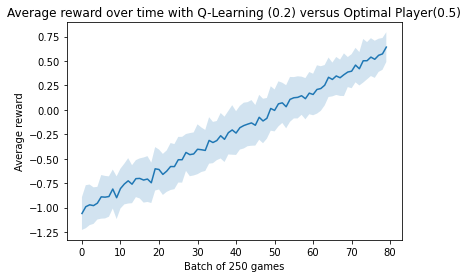

In [35]:
import matplotlib.pyplot as plt
mean = np.array([np.mean((np.sum(np.array(results), axis = 0)/5)[i*250:(i+1)*250]) for i in range(80)])
var = np.array([np.var((np.sum(np.array(results), axis = 0)/5)[i*250:(i+1)*250]) for i in range(80)])
plt.plot(np.arange(80),mean)
plt.fill_between(np.arange(80), mean-var/2, mean+var/2, alpha = 0.2)
plt.title("Average reward over time with Q-Learning (0.2) versus Optimal Player(0.5)")
plt.xlabel("Batch of 250 games")
plt.ylabel("Average reward")
np.save("Q1", results)

## Q3

### Calculations of $M_{opt}$

In [ ]:
results = []

for k in range(10):
    Turns = np.array(['X','O'])
    n_games = 20000
    winners = []
    count = []
    qvals = defaultdict(lambda: np.zeros(9))  
    assignments = defaultdict(lambda: len(assignments))
    alpha = 0.05
    gamma = 0.99
    max_eps = 0.8
    min_eps = 0.1
    n_star = 20000
    for i in range(1, n_games+1):
        # TESTING PHASE
        if i%250==0:
            print("Testing...")
            for w in range(500):
                current_testing = []
                #Reset the environment
                env.reset()
                grid, _, __ = env.observe()
                #Initialize the two players with epsilon 0
                player_opt_1 = OptimalPlayer(epsilon=0., player=Turns[w%2])
                player_q = Q_Player(epsilon=0., player=Turns[1 - w%2])
                for j in range(9):
                    if env.current_player == player_opt_1.player:
                        move = player_opt_1.act(grid)
                        grid, end, winner = env.step(move, print_grid=False)

                    else:
                        move = player_q.act(grid, assignments, qvals)
#                         assignments, _ = player_q.return_dicts()
                        grid, end, winner = env.step(move, print_grid=False)

                    if end:
                        current_testing.append(winner)
                        env.reset()
                        break
            winners.append(current_testing)
        # END OF TESTING               
        eps = max(min_eps, max_eps*(1-((i+1)/n_star)))
        print(k,i)
        env.reset()
        grid, _, __ = env.observe()
        player_opt_1 = OptimalPlayer(epsilon=0.5, player=Turns[i%2])
        player_q = Q_Player(epsilon=eps, player=Turns[1 - i%2])
        for j in range(9):
            if env.current_player == player_opt_1.player:
                move = player_opt_1.act(grid)
                grid, end, winner = env.step(move, print_grid=False)
                
            else:
                move = player_q.act(grid, assignments, qvals)
                assignments, qvals = player_q.return_dicts()
                last_move_q = convert(move)
                last_grid_q = assignments[str(grid)]
                grid, end, winner = env.step(move, print_grid=False)

            if (env.current_player == player_q.player and j!=0) or end:
                qvals[last_grid_q][last_move_q] += alpha*(env.reward(player=Turns[1 - i%2]) + gamma*np.nanmax(qvals[assignments[str(grid)]]) - qvals[last_grid_q][last_move_q])
            if end:
#                 winners.append(winner)
#                 count.append(env.reward(player=Turns[1 - i%2]))
                env.reset()
                break
    results.append(winners)

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
0 149
0 150
0 151
0 152
0 153
0 154
0 155
0 156
0 157
0 158
0 159
0 160
0 161
0 162
0 163
0 164
0 165
0 166
0 167
0 168
0 169
0 170
0 171
0 172
0 173
0 174
0 175
0 176
0 177
0 178
0 179
0 180
0 181
0 182
0 183
0 184
0 18

0 1337
0 1338
0 1339
0 1340
0 1341
0 1342
0 1343
0 1344
0 1345
0 1346
0 1347
0 1348
0 1349
0 1350
0 1351
0 1352
0 1353
0 1354
0 1355
0 1356
0 1357
0 1358
0 1359
0 1360
0 1361
0 1362
0 1363
0 1364
0 1365
0 1366
0 1367
0 1368
0 1369
0 1370
0 1371
0 1372
0 1373
0 1374
0 1375
0 1376
0 1377
0 1378
0 1379
0 1380
0 1381
0 1382
0 1383
0 1384
0 1385
0 1386
0 1387
0 1388
0 1389
0 1390
0 1391
0 1392
0 1393
0 1394
0 1395
0 1396
0 1397
0 1398
0 1399
0 1400
0 1401
0 1402
0 1403
0 1404
0 1405
0 1406
0 1407
0 1408
0 1409
0 1410
0 1411
0 1412
0 1413
0 1414
0 1415
0 1416
0 1417
0 1418
0 1419
0 1420
0 1421
0 1422
0 1423
0 1424
0 1425
0 1426
0 1427
0 1428
0 1429
0 1430
0 1431
0 1432
0 1433
0 1434
0 1435
0 1436
0 1437
0 1438
0 1439
0 1440
0 1441
0 1442
0 1443
0 1444
0 1445
0 1446
0 1447
0 1448
0 1449
0 1450
0 1451
0 1452
0 1453
0 1454
0 1455
0 1456
0 1457
0 1458
0 1459
0 1460
0 1461
0 1462
0 1463
0 1464
0 1465
0 1466
0 1467
0 1468
0 1469
0 1470
0 1471
0 1472
0 1473
0 1474
0 1475
0 1476
0 1477
0 1478
0 1479

0 2500
0 2501
0 2502
0 2503
0 2504
0 2505
0 2506
0 2507
0 2508
0 2509
0 2510
0 2511
0 2512
0 2513
0 2514
0 2515
0 2516
0 2517
0 2518
0 2519
0 2520
0 2521
0 2522
0 2523
0 2524
0 2525
0 2526
0 2527
0 2528
0 2529
0 2530
0 2531
0 2532
0 2533
0 2534
0 2535
0 2536
0 2537
0 2538
0 2539
0 2540
0 2541
0 2542
0 2543
0 2544
0 2545
0 2546
0 2547
0 2548
0 2549
0 2550
0 2551
0 2552
0 2553
0 2554
0 2555
0 2556
0 2557
0 2558
0 2559
0 2560
0 2561
0 2562
0 2563
0 2564
0 2565
0 2566
0 2567
0 2568
0 2569
0 2570
0 2571
0 2572
0 2573
0 2574
0 2575
0 2576
0 2577
0 2578
0 2579
0 2580
0 2581
0 2582
0 2583
0 2584
0 2585
0 2586
0 2587
0 2588
0 2589
0 2590
0 2591
0 2592
0 2593
0 2594
0 2595
0 2596
0 2597
0 2598
0 2599
0 2600
0 2601
0 2602
0 2603
0 2604
0 2605
0 2606
0 2607
0 2608
0 2609
0 2610
0 2611
0 2612
0 2613
0 2614
0 2615
0 2616
0 2617
0 2618
0 2619
0 2620
0 2621
0 2622
0 2623
0 2624
0 2625
0 2626
0 2627
0 2628
0 2629
0 2630
0 2631
0 2632
0 2633
0 2634
0 2635
0 2636
0 2637
0 2638
0 2639
0 2640
0 2641
0 2642

0 3673
0 3674
0 3675
0 3676
0 3677
0 3678
0 3679
0 3680
0 3681
0 3682
0 3683
0 3684
0 3685
0 3686
0 3687
0 3688
0 3689
0 3690
0 3691
0 3692
0 3693
0 3694
0 3695
0 3696
0 3697
0 3698
0 3699
0 3700
0 3701
0 3702
0 3703
0 3704
0 3705
0 3706
0 3707
0 3708
0 3709
0 3710
0 3711
0 3712
0 3713
0 3714
0 3715
0 3716
0 3717
0 3718
0 3719
0 3720
0 3721
0 3722
0 3723
0 3724
0 3725
0 3726
0 3727
0 3728
0 3729
0 3730
0 3731
0 3732
0 3733
0 3734
0 3735
0 3736
0 3737
0 3738
0 3739
0 3740
0 3741
0 3742
0 3743
0 3744
0 3745
0 3746
0 3747
0 3748
0 3749
Testing...
0 3750
0 3751
0 3752
0 3753
0 3754
0 3755
0 3756
0 3757
0 3758
0 3759
0 3760
0 3761
0 3762
0 3763
0 3764
0 3765
0 3766
0 3767
0 3768
0 3769
0 3770
0 3771
0 3772
0 3773
0 3774
0 3775
0 3776
0 3777
0 3778
0 3779
0 3780
0 3781
0 3782
0 3783
0 3784
0 3785
0 3786
0 3787
0 3788
0 3789
0 3790
0 3791
0 3792
0 3793
0 3794
0 3795
0 3796
0 3797
0 3798
0 3799
0 3800
0 3801
0 3802
0 3803
0 3804
0 3805
0 3806
0 3807
0 3808
0 3809
0 3810
0 3811
0 3812
0 3813
0 

0 4836
0 4837
0 4838
0 4839
0 4840
0 4841
0 4842
0 4843
0 4844
0 4845
0 4846
0 4847
0 4848
0 4849
0 4850
0 4851
0 4852
0 4853
0 4854
0 4855
0 4856
0 4857
0 4858
0 4859
0 4860
0 4861
0 4862
0 4863
0 4864
0 4865
0 4866
0 4867
0 4868
0 4869
0 4870
0 4871
0 4872
0 4873
0 4874
0 4875
0 4876
0 4877
0 4878
0 4879
0 4880
0 4881
0 4882
0 4883
0 4884
0 4885
0 4886
0 4887
0 4888
0 4889
0 4890
0 4891
0 4892
0 4893
0 4894
0 4895
0 4896
0 4897
0 4898
0 4899
0 4900
0 4901
0 4902
0 4903
0 4904
0 4905
0 4906
0 4907
0 4908
0 4909
0 4910
0 4911
0 4912
0 4913
0 4914
0 4915
0 4916
0 4917
0 4918
0 4919
0 4920
0 4921
0 4922
0 4923
0 4924
0 4925
0 4926
0 4927
0 4928
0 4929
0 4930
0 4931
0 4932
0 4933
0 4934
0 4935
0 4936
0 4937
0 4938
0 4939
0 4940
0 4941
0 4942
0 4943
0 4944
0 4945
0 4946
0 4947
0 4948
0 4949
0 4950
0 4951
0 4952
0 4953
0 4954
0 4955
0 4956
0 4957
0 4958
0 4959
0 4960
0 4961
0 4962
0 4963
0 4964
0 4965
0 4966
0 4967
0 4968
0 4969
0 4970
0 4971
0 4972
0 4973
0 4974
0 4975
0 4976
0 4977
0 4978

0 6000
0 6001
0 6002
0 6003
0 6004
0 6005
0 6006
0 6007
0 6008
0 6009
0 6010
0 6011
0 6012
0 6013
0 6014
0 6015
0 6016
0 6017
0 6018
0 6019
0 6020
0 6021
0 6022
0 6023
0 6024
0 6025
0 6026
0 6027
0 6028
0 6029
0 6030
0 6031
0 6032
0 6033
0 6034
0 6035
0 6036
0 6037
0 6038
0 6039
0 6040
0 6041
0 6042
0 6043
0 6044
0 6045
0 6046
0 6047
0 6048
0 6049
0 6050
0 6051
0 6052
0 6053
0 6054
0 6055
0 6056
0 6057
0 6058
0 6059
0 6060
0 6061
0 6062
0 6063
0 6064
0 6065
0 6066
0 6067
0 6068
0 6069
0 6070
0 6071
0 6072
0 6073
0 6074
0 6075
0 6076
0 6077
0 6078
0 6079
0 6080
0 6081
0 6082
0 6083
0 6084
0 6085
0 6086
0 6087
0 6088
0 6089
0 6090
0 6091
0 6092
0 6093
0 6094
0 6095
0 6096
0 6097
0 6098
0 6099
0 6100
0 6101
0 6102
0 6103
0 6104
0 6105
0 6106
0 6107
0 6108
0 6109
0 6110
0 6111
0 6112
0 6113
0 6114
0 6115
0 6116
0 6117
0 6118
0 6119
0 6120
0 6121
0 6122
0 6123
0 6124
0 6125
0 6126
0 6127
0 6128
0 6129
0 6130
0 6131
0 6132
0 6133
0 6134
0 6135
0 6136
0 6137
0 6138
0 6139
0 6140
0 6141
0 6142

0 7172
0 7173
0 7174
0 7175
0 7176
0 7177
0 7178
0 7179
0 7180
0 7181
0 7182
0 7183
0 7184
0 7185
0 7186
0 7187
0 7188
0 7189
0 7190
0 7191
0 7192
0 7193
0 7194
0 7195
0 7196
0 7197
0 7198
0 7199
0 7200
0 7201
0 7202
0 7203
0 7204
0 7205
0 7206
0 7207
0 7208
0 7209
0 7210
0 7211
0 7212
0 7213
0 7214
0 7215
0 7216
0 7217
0 7218
0 7219
0 7220
0 7221
0 7222
0 7223
0 7224
0 7225
0 7226
0 7227
0 7228
0 7229
0 7230
0 7231
0 7232
0 7233
0 7234
0 7235
0 7236
0 7237
0 7238
0 7239
0 7240
0 7241
0 7242
0 7243
0 7244
0 7245
0 7246
0 7247
0 7248
0 7249
Testing...
0 7250
0 7251
0 7252
0 7253
0 7254
0 7255
0 7256
0 7257
0 7258
0 7259
0 7260
0 7261
0 7262
0 7263
0 7264
0 7265
0 7266
0 7267
0 7268
0 7269
0 7270
0 7271
0 7272
0 7273
0 7274
0 7275
0 7276
0 7277
0 7278
0 7279
0 7280
0 7281
0 7282
0 7283
0 7284
0 7285
0 7286
0 7287
0 7288
0 7289
0 7290
0 7291
0 7292
0 7293
0 7294
0 7295
0 7296
0 7297
0 7298
0 7299
0 7300
0 7301
0 7302
0 7303
0 7304
0 7305
0 7306
0 7307
0 7308
0 7309
0 7310
0 7311
0 7312
0 

0 8340
0 8341
0 8342
0 8343
0 8344
0 8345
0 8346
0 8347
0 8348
0 8349
0 8350
0 8351
0 8352
0 8353
0 8354
0 8355
0 8356
0 8357
0 8358
0 8359
0 8360
0 8361
0 8362
0 8363
0 8364
0 8365
0 8366
0 8367
0 8368
0 8369
0 8370
0 8371
0 8372
0 8373
0 8374
0 8375
0 8376
0 8377
0 8378
0 8379
0 8380
0 8381
0 8382
0 8383
0 8384
0 8385
0 8386
0 8387
0 8388
0 8389
0 8390
0 8391
0 8392
0 8393
0 8394
0 8395
0 8396
0 8397
0 8398
0 8399
0 8400
0 8401
0 8402
0 8403
0 8404
0 8405
0 8406
0 8407
0 8408
0 8409
0 8410
0 8411
0 8412
0 8413
0 8414
0 8415
0 8416
0 8417
0 8418
0 8419
0 8420
0 8421
0 8422
0 8423
0 8424
0 8425
0 8426
0 8427
0 8428
0 8429
0 8430
0 8431
0 8432
0 8433
0 8434
0 8435
0 8436
0 8437
0 8438
0 8439
0 8440
0 8441
0 8442
0 8443
0 8444
0 8445
0 8446
0 8447
0 8448
0 8449
0 8450
0 8451
0 8452
0 8453
0 8454
0 8455
0 8456
0 8457
0 8458
0 8459
0 8460
0 8461
0 8462
0 8463
0 8464
0 8465
0 8466
0 8467
0 8468
0 8469
0 8470
0 8471
0 8472
0 8473
0 8474
0 8475
0 8476
0 8477
0 8478
0 8479
0 8480
0 8481
0 8482

0 9527
0 9528
0 9529
0 9530
0 9531
0 9532
0 9533
0 9534
0 9535
0 9536
0 9537
0 9538
0 9539
0 9540
0 9541
0 9542
0 9543
0 9544
0 9545
0 9546
0 9547
0 9548
0 9549
0 9550
0 9551
0 9552
0 9553
0 9554
0 9555
0 9556
0 9557
0 9558
0 9559
0 9560
0 9561
0 9562
0 9563
0 9564
0 9565
0 9566
0 9567
0 9568
0 9569
0 9570
0 9571
0 9572
0 9573
0 9574
0 9575
0 9576
0 9577
0 9578
0 9579
0 9580
0 9581
0 9582
0 9583
0 9584
0 9585
0 9586
0 9587
0 9588
0 9589
0 9590
0 9591
0 9592
0 9593
0 9594
0 9595
0 9596
0 9597
0 9598
0 9599
0 9600
0 9601
0 9602
0 9603
0 9604
0 9605
0 9606
0 9607
0 9608
0 9609
0 9610
0 9611
0 9612
0 9613
0 9614
0 9615
0 9616
0 9617
0 9618
0 9619
0 9620
0 9621
0 9622
0 9623
0 9624
0 9625
0 9626
0 9627
0 9628
0 9629
0 9630
0 9631
0 9632
0 9633
0 9634
0 9635
0 9636
0 9637
0 9638
0 9639
0 9640
0 9641
0 9642
0 9643
0 9644
0 9645
0 9646
0 9647
0 9648
0 9649
0 9650
0 9651
0 9652
0 9653
0 9654
0 9655
0 9656
0 9657
0 9658
0 9659
0 9660
0 9661
0 9662
0 9663
0 9664
0 9665
0 9666
0 9667
0 9668
0 9669

0 10622
0 10623
0 10624
0 10625
0 10626
0 10627
0 10628
0 10629
0 10630
0 10631
0 10632
0 10633
0 10634
0 10635
0 10636
0 10637
0 10638
0 10639
0 10640
0 10641
0 10642
0 10643
0 10644
0 10645
0 10646
0 10647
0 10648
0 10649
0 10650
0 10651
0 10652
0 10653
0 10654
0 10655
0 10656
0 10657
0 10658
0 10659
0 10660
0 10661
0 10662
0 10663
0 10664
0 10665
0 10666
0 10667
0 10668
0 10669
0 10670
0 10671
0 10672
0 10673
0 10674
0 10675
0 10676
0 10677
0 10678
0 10679
0 10680
0 10681
0 10682
0 10683
0 10684
0 10685
0 10686
0 10687
0 10688
0 10689
0 10690
0 10691
0 10692
0 10693
0 10694
0 10695
0 10696
0 10697
0 10698
0 10699
0 10700
0 10701
0 10702
0 10703
0 10704
0 10705
0 10706
0 10707
0 10708
0 10709
0 10710
0 10711
0 10712
0 10713
0 10714
0 10715
0 10716
0 10717
0 10718
0 10719
0 10720
0 10721
0 10722
0 10723
0 10724
0 10725
0 10726
0 10727
0 10728
0 10729
0 10730
0 10731
0 10732
0 10733
0 10734
0 10735
0 10736
0 10737
0 10738
0 10739
0 10740
0 10741
0 10742
0 10743
0 10744
0 10745
0 10746


0 11661
0 11662
0 11663
0 11664
0 11665
0 11666
0 11667
0 11668
0 11669
0 11670
0 11671
0 11672
0 11673
0 11674
0 11675
0 11676
0 11677
0 11678
0 11679
0 11680
0 11681
0 11682
0 11683
0 11684
0 11685
0 11686
0 11687
0 11688
0 11689
0 11690
0 11691
0 11692
0 11693
0 11694
0 11695
0 11696
0 11697
0 11698
0 11699
0 11700
0 11701
0 11702
0 11703
0 11704
0 11705
0 11706
0 11707
0 11708
0 11709
0 11710
0 11711
0 11712
0 11713
0 11714
0 11715
0 11716
0 11717
0 11718
0 11719
0 11720
0 11721
0 11722
0 11723
0 11724
0 11725
0 11726
0 11727
0 11728
0 11729
0 11730
0 11731
0 11732
0 11733
0 11734
0 11735
0 11736
0 11737
0 11738
0 11739
0 11740
0 11741
0 11742
0 11743
0 11744
0 11745
0 11746
0 11747
0 11748
0 11749
Testing...
0 11750
0 11751
0 11752
0 11753
0 11754
0 11755
0 11756
0 11757
0 11758
0 11759
0 11760
0 11761
0 11762
0 11763
0 11764
0 11765
0 11766
0 11767
0 11768
0 11769
0 11770
0 11771
0 11772
0 11773
0 11774
0 11775
0 11776
0 11777
0 11778
0 11779
0 11780
0 11781
0 11782
0 11783
0 117

0 12680
0 12681
0 12682
0 12683
0 12684
0 12685
0 12686
0 12687
0 12688
0 12689
0 12690
0 12691
0 12692
0 12693
0 12694
0 12695
0 12696
0 12697
0 12698
0 12699
0 12700
0 12701
0 12702
0 12703
0 12704
0 12705
0 12706
0 12707
0 12708
0 12709
0 12710
0 12711
0 12712
0 12713
0 12714
0 12715
0 12716
0 12717
0 12718
0 12719
0 12720
0 12721
0 12722
0 12723
0 12724
0 12725
0 12726
0 12727
0 12728
0 12729
0 12730
0 12731
0 12732
0 12733
0 12734
0 12735
0 12736
0 12737
0 12738
0 12739
0 12740
0 12741
0 12742
0 12743
0 12744
0 12745
0 12746
0 12747
0 12748
0 12749
Testing...
0 12750
0 12751
0 12752
0 12753
0 12754
0 12755
0 12756
0 12757
0 12758
0 12759
0 12760
0 12761
0 12762
0 12763
0 12764
0 12765
0 12766
0 12767
0 12768
0 12769
0 12770
0 12771
0 12772
0 12773
0 12774
0 12775
0 12776
0 12777
0 12778
0 12779
0 12780
0 12781
0 12782
0 12783
0 12784
0 12785
0 12786
0 12787
0 12788
0 12789
0 12790
0 12791
0 12792
0 12793
0 12794
0 12795
0 12796
0 12797
0 12798
0 12799
0 12800
0 12801
0 12802
0 128

0 13703
0 13704
0 13705
0 13706
0 13707
0 13708
0 13709
0 13710
0 13711
0 13712
0 13713
0 13714
0 13715
0 13716
0 13717
0 13718
0 13719
0 13720
0 13721
0 13722
0 13723
0 13724
0 13725
0 13726
0 13727
0 13728
0 13729
0 13730
0 13731
0 13732
0 13733
0 13734
0 13735
0 13736
0 13737
0 13738
0 13739
0 13740
0 13741
0 13742
0 13743
0 13744
0 13745
0 13746
0 13747
0 13748
0 13749
Testing...
0 13750
0 13751
0 13752
0 13753
0 13754
0 13755
0 13756
0 13757
0 13758
0 13759
0 13760
0 13761
0 13762
0 13763
0 13764
0 13765
0 13766
0 13767
0 13768
0 13769
0 13770
0 13771
0 13772
0 13773
0 13774
0 13775
0 13776
0 13777
0 13778
0 13779
0 13780
0 13781
0 13782
0 13783
0 13784
0 13785
0 13786
0 13787
0 13788
0 13789
0 13790
0 13791
0 13792
0 13793
0 13794
0 13795
0 13796
0 13797
0 13798
0 13799
0 13800
0 13801
0 13802
0 13803
0 13804
0 13805
0 13806
0 13807
0 13808
0 13809
0 13810
0 13811
0 13812
0 13813
0 13814
0 13815
0 13816
0 13817
0 13818
0 13819
0 13820
0 13821
0 13822
0 13823
0 13824
0 13825
0 138

0 14742
0 14743
0 14744
0 14745
0 14746
0 14747
0 14748
0 14749
Testing...
0 14750
0 14751
0 14752
0 14753
0 14754
0 14755
0 14756
0 14757
0 14758
0 14759
0 14760
0 14761
0 14762
0 14763
0 14764
0 14765
0 14766
0 14767
0 14768
0 14769
0 14770
0 14771
0 14772
0 14773
0 14774
0 14775
0 14776
0 14777
0 14778
0 14779
0 14780
0 14781
0 14782
0 14783
0 14784
0 14785
0 14786
0 14787
0 14788
0 14789
0 14790
0 14791
0 14792
0 14793
0 14794
0 14795
0 14796
0 14797
0 14798
0 14799
0 14800
0 14801
0 14802
0 14803
0 14804
0 14805
0 14806
0 14807
0 14808
0 14809
0 14810
0 14811
0 14812
0 14813
0 14814
0 14815
0 14816
0 14817
0 14818
0 14819
0 14820
0 14821
0 14822
0 14823
0 14824
0 14825
0 14826
0 14827
0 14828
0 14829
0 14830
0 14831
0 14832
0 14833
0 14834
0 14835
0 14836
0 14837
0 14838
0 14839
0 14840
0 14841
0 14842
0 14843
0 14844
0 14845
0 14846
0 14847
0 14848
0 14849
0 14850
0 14851
0 14852
0 14853
0 14854
0 14855
0 14856
0 14857
0 14858
0 14859
0 14860
0 14861
0 14862
0 14863
0 14864
0 148

0 15782
0 15783
0 15784
0 15785
0 15786
0 15787
0 15788
0 15789
0 15790
0 15791
0 15792
0 15793
0 15794
0 15795
0 15796
0 15797
0 15798
0 15799
0 15800
0 15801
0 15802
0 15803
0 15804
0 15805
0 15806
0 15807
0 15808
0 15809
0 15810
0 15811
0 15812
0 15813
0 15814
0 15815
0 15816
0 15817
0 15818
0 15819
0 15820
0 15821
0 15822
0 15823
0 15824
0 15825
0 15826
0 15827
0 15828
0 15829
0 15830
0 15831
0 15832
0 15833
0 15834
0 15835
0 15836
0 15837
0 15838
0 15839
0 15840
0 15841
0 15842
0 15843
0 15844
0 15845
0 15846
0 15847
0 15848
0 15849
0 15850
0 15851
0 15852
0 15853
0 15854
0 15855
0 15856
0 15857
0 15858
0 15859
0 15860
0 15861
0 15862
0 15863
0 15864
0 15865
0 15866
0 15867
0 15868
0 15869
0 15870
0 15871
0 15872
0 15873
0 15874
0 15875
0 15876
0 15877
0 15878
0 15879
0 15880
0 15881
0 15882
0 15883
0 15884
0 15885
0 15886
0 15887
0 15888
0 15889
0 15890
0 15891
0 15892
0 15893
0 15894
0 15895
0 15896
0 15897
0 15898
0 15899
0 15900
0 15901
0 15902
0 15903
0 15904
0 15905
0 15906


0 16801
0 16802
0 16803
0 16804
0 16805
0 16806
0 16807
0 16808
0 16809
0 16810
0 16811
0 16812
0 16813
0 16814
0 16815
0 16816
0 16817
0 16818
0 16819
0 16820
0 16821
0 16822
0 16823
0 16824
0 16825
0 16826
0 16827
0 16828
0 16829
0 16830
0 16831
0 16832
0 16833
0 16834
0 16835
0 16836
0 16837
0 16838
0 16839
0 16840
0 16841
0 16842
0 16843
0 16844
0 16845
0 16846
0 16847
0 16848
0 16849
0 16850
0 16851
0 16852
0 16853
0 16854
0 16855
0 16856
0 16857
0 16858
0 16859
0 16860
0 16861
0 16862
0 16863
0 16864
0 16865
0 16866
0 16867
0 16868
0 16869
0 16870
0 16871
0 16872
0 16873
0 16874
0 16875
0 16876
0 16877
0 16878
0 16879
0 16880
0 16881
0 16882
0 16883
0 16884
0 16885
0 16886
0 16887
0 16888
0 16889
0 16890
0 16891
0 16892
0 16893
0 16894
0 16895
0 16896
0 16897
0 16898
0 16899
0 16900
0 16901
0 16902
0 16903
0 16904
0 16905
0 16906
0 16907
0 16908
0 16909
0 16910
0 16911
0 16912
0 16913
0 16914
0 16915
0 16916
0 16917
0 16918
0 16919
0 16920
0 16921
0 16922
0 16923
0 16924
0 16925


0 17838
0 17839
0 17840
0 17841
0 17842
0 17843
0 17844
0 17845
0 17846
0 17847
0 17848
0 17849
0 17850
0 17851
0 17852
0 17853
0 17854
0 17855
0 17856
0 17857
0 17858
0 17859
0 17860
0 17861
0 17862
0 17863
0 17864
0 17865
0 17866
0 17867
0 17868
0 17869
0 17870
0 17871
0 17872
0 17873
0 17874
0 17875
0 17876
0 17877
0 17878
0 17879
0 17880
0 17881
0 17882
0 17883
0 17884
0 17885
0 17886
0 17887
0 17888
0 17889
0 17890
0 17891
0 17892
0 17893
0 17894
0 17895
0 17896
0 17897
0 17898
0 17899
0 17900
0 17901
0 17902
0 17903
0 17904
0 17905
0 17906
0 17907
0 17908
0 17909
0 17910
0 17911
0 17912
0 17913
0 17914
0 17915
0 17916
0 17917
0 17918
0 17919
0 17920
0 17921
0 17922
0 17923
0 17924
0 17925
0 17926
0 17927
0 17928
0 17929
0 17930
0 17931
0 17932
0 17933
0 17934
0 17935
0 17936
0 17937
0 17938
0 17939
0 17940
0 17941
0 17942
0 17943
0 17944
0 17945
0 17946
0 17947
0 17948
0 17949
0 17950
0 17951
0 17952
0 17953
0 17954
0 17955
0 17956
0 17957
0 17958
0 17959
0 17960
0 17961
0 17962


0 18864
0 18865
0 18866
0 18867
0 18868
0 18869
0 18870
0 18871
0 18872
0 18873
0 18874
0 18875
0 18876
0 18877
0 18878
0 18879
0 18880
0 18881
0 18882
0 18883
0 18884
0 18885
0 18886
0 18887
0 18888
0 18889
0 18890
0 18891
0 18892
0 18893
0 18894
0 18895
0 18896
0 18897
0 18898
0 18899
0 18900
0 18901
0 18902
0 18903
0 18904
0 18905
0 18906
0 18907
0 18908
0 18909
0 18910
0 18911
0 18912
0 18913
0 18914
0 18915
0 18916
0 18917
0 18918
0 18919
0 18920
0 18921
0 18922
0 18923
0 18924
0 18925
0 18926
0 18927
0 18928
0 18929
0 18930
0 18931
0 18932
0 18933
0 18934
0 18935
0 18936
0 18937
0 18938
0 18939
0 18940
0 18941
0 18942
0 18943
0 18944
0 18945
0 18946
0 18947
0 18948
0 18949
0 18950
0 18951
0 18952
0 18953
0 18954
0 18955
0 18956
0 18957
0 18958
0 18959
0 18960
0 18961
0 18962
0 18963
0 18964
0 18965
0 18966
0 18967
0 18968
0 18969
0 18970
0 18971
0 18972
0 18973
0 18974
0 18975
0 18976
0 18977
0 18978
0 18979
0 18980
0 18981
0 18982
0 18983
0 18984
0 18985
0 18986
0 18987
0 18988


0 19899
0 19900
0 19901
0 19902
0 19903
0 19904
0 19905
0 19906
0 19907
0 19908
0 19909
0 19910
0 19911
0 19912
0 19913
0 19914
0 19915
0 19916
0 19917
0 19918
0 19919
0 19920
0 19921
0 19922
0 19923
0 19924
0 19925
0 19926
0 19927
0 19928
0 19929
0 19930
0 19931
0 19932
0 19933
0 19934
0 19935
0 19936
0 19937
0 19938
0 19939
0 19940
0 19941
0 19942
0 19943
0 19944
0 19945
0 19946
0 19947
0 19948
0 19949
0 19950
0 19951
0 19952
0 19953
0 19954
0 19955
0 19956
0 19957
0 19958
0 19959
0 19960
0 19961
0 19962
0 19963
0 19964
0 19965
0 19966
0 19967
0 19968
0 19969
0 19970
0 19971
0 19972
0 19973
0 19974
0 19975
0 19976
0 19977
0 19978
0 19979
0 19980
0 19981
0 19982
0 19983
0 19984
0 19985
0 19986
0 19987
0 19988
0 19989
0 19990
0 19991
0 19992
0 19993
0 19994
0 19995
0 19996
0 19997
0 19998
0 19999
Testing...
0 20000
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 

1 1209
1 1210
1 1211
1 1212
1 1213
1 1214
1 1215
1 1216
1 1217
1 1218
1 1219
1 1220
1 1221
1 1222
1 1223
1 1224
1 1225
1 1226
1 1227
1 1228
1 1229
1 1230
1 1231
1 1232
1 1233
1 1234
1 1235
1 1236
1 1237
1 1238
1 1239
1 1240
1 1241
1 1242
1 1243
1 1244
1 1245
1 1246
1 1247
1 1248
1 1249
Testing...
1 1250
1 1251
1 1252
1 1253
1 1254
1 1255
1 1256
1 1257
1 1258
1 1259
1 1260
1 1261
1 1262
1 1263
1 1264
1 1265
1 1266
1 1267
1 1268
1 1269
1 1270
1 1271
1 1272
1 1273
1 1274
1 1275
1 1276
1 1277
1 1278
1 1279
1 1280
1 1281
1 1282
1 1283
1 1284
1 1285
1 1286
1 1287
1 1288
1 1289
1 1290
1 1291
1 1292
1 1293
1 1294
1 1295
1 1296
1 1297
1 1298
1 1299
1 1300
1 1301
1 1302
1 1303
1 1304
1 1305
1 1306
1 1307
1 1308
1 1309
1 1310
1 1311
1 1312
1 1313
1 1314
1 1315
1 1316
1 1317
1 1318
1 1319
1 1320
1 1321
1 1322
1 1323
1 1324
1 1325
1 1326
1 1327
1 1328
1 1329
1 1330
1 1331
1 1332
1 1333
1 1334
1 1335
1 1336
1 1337
1 1338
1 1339
1 1340
1 1341
1 1342
1 1343
1 1344
1 1345
1 1346
1 1347
1 1348
1 1349
1 

1 2390
1 2391
1 2392
1 2393
1 2394
1 2395
1 2396
1 2397
1 2398
1 2399
1 2400
1 2401
1 2402
1 2403
1 2404
1 2405
1 2406
1 2407
1 2408
1 2409
1 2410
1 2411
1 2412
1 2413
1 2414
1 2415
1 2416
1 2417
1 2418
1 2419
1 2420
1 2421
1 2422
1 2423
1 2424
1 2425
1 2426
1 2427
1 2428
1 2429
1 2430
1 2431
1 2432
1 2433
1 2434
1 2435
1 2436
1 2437
1 2438
1 2439
1 2440
1 2441
1 2442
1 2443
1 2444
1 2445
1 2446
1 2447
1 2448
1 2449
1 2450
1 2451
1 2452
1 2453
1 2454
1 2455
1 2456
1 2457
1 2458
1 2459
1 2460
1 2461
1 2462
1 2463
1 2464
1 2465
1 2466
1 2467
1 2468
1 2469
1 2470
1 2471
1 2472
1 2473
1 2474
1 2475
1 2476
1 2477
1 2478
1 2479
1 2480
1 2481
1 2482
1 2483
1 2484
1 2485
1 2486
1 2487
1 2488
1 2489
1 2490
1 2491
1 2492
1 2493
1 2494
1 2495
1 2496
1 2497
1 2498
1 2499
Testing...
1 2500
1 2501
1 2502
1 2503
1 2504
1 2505
1 2506
1 2507
1 2508
1 2509
1 2510
1 2511
1 2512
1 2513
1 2514
1 2515
1 2516
1 2517
1 2518
1 2519
1 2520
1 2521
1 2522
1 2523
1 2524
1 2525
1 2526
1 2527
1 2528
1 2529
1 2530
1 

1 3583
1 3584
1 3585
1 3586
1 3587
1 3588
1 3589
1 3590
1 3591
1 3592
1 3593
1 3594
1 3595
1 3596
1 3597
1 3598
1 3599
1 3600
1 3601
1 3602
1 3603
1 3604
1 3605
1 3606
1 3607
1 3608
1 3609
1 3610
1 3611
1 3612
1 3613
1 3614
1 3615
1 3616
1 3617
1 3618
1 3619
1 3620
1 3621
1 3622
1 3623
1 3624
1 3625
1 3626
1 3627
1 3628
1 3629
1 3630
1 3631
1 3632
1 3633
1 3634
1 3635
1 3636
1 3637
1 3638
1 3639
1 3640
1 3641
1 3642
1 3643
1 3644
1 3645
1 3646
1 3647
1 3648
1 3649
1 3650
1 3651
1 3652
1 3653
1 3654
1 3655
1 3656
1 3657
1 3658
1 3659
1 3660
1 3661
1 3662
1 3663
1 3664
1 3665
1 3666
1 3667
1 3668
1 3669
1 3670
1 3671
1 3672
1 3673
1 3674
1 3675
1 3676
1 3677
1 3678
1 3679
1 3680
1 3681
1 3682
1 3683
1 3684
1 3685
1 3686
1 3687
1 3688
1 3689
1 3690
1 3691
1 3692
1 3693
1 3694
1 3695
1 3696
1 3697
1 3698
1 3699
1 3700
1 3701
1 3702
1 3703
1 3704
1 3705
1 3706
1 3707
1 3708
1 3709
1 3710
1 3711
1 3712
1 3713
1 3714
1 3715
1 3716
1 3717
1 3718
1 3719
1 3720
1 3721
1 3722
1 3723
1 3724
1 3725

1 4750
1 4751
1 4752
1 4753
1 4754
1 4755
1 4756
1 4757
1 4758
1 4759
1 4760
1 4761
1 4762
1 4763
1 4764
1 4765
1 4766
1 4767
1 4768
1 4769
1 4770
1 4771
1 4772
1 4773
1 4774
1 4775
1 4776
1 4777
1 4778
1 4779
1 4780
1 4781
1 4782
1 4783
1 4784
1 4785
1 4786
1 4787
1 4788
1 4789
1 4790
1 4791
1 4792
1 4793
1 4794
1 4795
1 4796
1 4797
1 4798
1 4799
1 4800
1 4801
1 4802
1 4803
1 4804
1 4805
1 4806
1 4807
1 4808
1 4809
1 4810
1 4811
1 4812
1 4813
1 4814
1 4815
1 4816
1 4817
1 4818
1 4819
1 4820
1 4821
1 4822
1 4823
1 4824
1 4825
1 4826
1 4827
1 4828
1 4829
1 4830
1 4831
1 4832
1 4833
1 4834
1 4835
1 4836
1 4837
1 4838
1 4839
1 4840
1 4841
1 4842
1 4843
1 4844
1 4845
1 4846
1 4847
1 4848
1 4849
1 4850
1 4851
1 4852
1 4853
1 4854
1 4855
1 4856
1 4857
1 4858
1 4859
1 4860
1 4861
1 4862
1 4863
1 4864
1 4865
1 4866
1 4867
1 4868
1 4869
1 4870
1 4871
1 4872
1 4873
1 4874
1 4875
1 4876
1 4877
1 4878
1 4879
1 4880
1 4881
1 4882
1 4883
1 4884
1 4885
1 4886
1 4887
1 4888
1 4889
1 4890
1 4891
1 4892

1 5926
1 5927
1 5928
1 5929
1 5930
1 5931
1 5932
1 5933
1 5934
1 5935
1 5936
1 5937
1 5938
1 5939
1 5940
1 5941
1 5942
1 5943
1 5944
1 5945
1 5946
1 5947
1 5948
1 5949
1 5950
1 5951
1 5952
1 5953
1 5954
1 5955
1 5956
1 5957
1 5958
1 5959
1 5960
1 5961
1 5962
1 5963
1 5964
1 5965
1 5966
1 5967
1 5968
1 5969
1 5970
1 5971
1 5972
1 5973
1 5974
1 5975
1 5976
1 5977
1 5978
1 5979
1 5980
1 5981
1 5982
1 5983
1 5984
1 5985
1 5986
1 5987
1 5988
1 5989
1 5990
1 5991
1 5992
1 5993
1 5994
1 5995
1 5996
1 5997
1 5998
1 5999
Testing...
1 6000
1 6001
1 6002
1 6003
1 6004
1 6005
1 6006
1 6007
1 6008
1 6009
1 6010
1 6011
1 6012
1 6013
1 6014
1 6015
1 6016
1 6017
1 6018
1 6019
1 6020
1 6021
1 6022
1 6023
1 6024
1 6025
1 6026
1 6027
1 6028
1 6029
1 6030
1 6031
1 6032
1 6033
1 6034
1 6035
1 6036
1 6037
1 6038
1 6039
1 6040
1 6041
1 6042
1 6043
1 6044
1 6045
1 6046
1 6047
1 6048
1 6049
1 6050
1 6051
1 6052
1 6053
1 6054
1 6055
1 6056
1 6057
1 6058
1 6059
1 6060
1 6061
1 6062
1 6063
1 6064
1 6065
1 6066
1 

1 7114
1 7115
1 7116
1 7117
1 7118
1 7119
1 7120
1 7121
1 7122
1 7123
1 7124
1 7125
1 7126
1 7127
1 7128
1 7129
1 7130
1 7131
1 7132
1 7133
1 7134
1 7135
1 7136
1 7137
1 7138
1 7139
1 7140
1 7141
1 7142
1 7143
1 7144
1 7145
1 7146
1 7147
1 7148
1 7149
1 7150
1 7151
1 7152
1 7153
1 7154
1 7155
1 7156
1 7157
1 7158
1 7159
1 7160
1 7161
1 7162
1 7163
1 7164
1 7165
1 7166
1 7167
1 7168
1 7169
1 7170
1 7171
1 7172
1 7173
1 7174
1 7175
1 7176
1 7177
1 7178
1 7179
1 7180
1 7181
1 7182
1 7183
1 7184
1 7185
1 7186
1 7187
1 7188
1 7189
1 7190
1 7191
1 7192
1 7193
1 7194
1 7195
1 7196
1 7197
1 7198
1 7199
1 7200
1 7201
1 7202
1 7203
1 7204
1 7205
1 7206
1 7207
1 7208
1 7209
1 7210
1 7211
1 7212
1 7213
1 7214
1 7215
1 7216
1 7217
1 7218
1 7219
1 7220
1 7221
1 7222
1 7223
1 7224
1 7225
1 7226
1 7227
1 7228
1 7229
1 7230
1 7231
1 7232
1 7233
1 7234
1 7235
1 7236
1 7237
1 7238
1 7239
1 7240
1 7241
1 7242
1 7243
1 7244
1 7245
1 7246
1 7247
1 7248
1 7249
Testing...
1 7250
1 7251
1 7252
1 7253
1 7254
1 

1 8301
1 8302
1 8303
1 8304
1 8305
1 8306
1 8307
1 8308
1 8309
1 8310
1 8311
1 8312
1 8313
1 8314
1 8315
1 8316
1 8317
1 8318
1 8319
1 8320
1 8321
1 8322
1 8323
1 8324
1 8325
1 8326
1 8327
1 8328
1 8329
1 8330
1 8331
1 8332
1 8333
1 8334
1 8335
1 8336
1 8337
1 8338
1 8339
1 8340
1 8341
1 8342
1 8343
1 8344
1 8345
1 8346
1 8347
1 8348
1 8349
1 8350
1 8351
1 8352
1 8353
1 8354
1 8355
1 8356
1 8357
1 8358
1 8359
1 8360
1 8361
1 8362
1 8363
1 8364
1 8365
1 8366
1 8367
1 8368
1 8369
1 8370
1 8371
1 8372
1 8373
1 8374
1 8375
1 8376
1 8377
1 8378
1 8379
1 8380
1 8381
1 8382
1 8383
1 8384
1 8385
1 8386
1 8387
1 8388
1 8389
1 8390
1 8391
1 8392
1 8393
1 8394
1 8395
1 8396
1 8397
1 8398
1 8399
1 8400
1 8401
1 8402
1 8403
1 8404
1 8405
1 8406
1 8407
1 8408
1 8409
1 8410
1 8411
1 8412
1 8413
1 8414
1 8415
1 8416
1 8417
1 8418
1 8419
1 8420
1 8421
1 8422
1 8423
1 8424
1 8425
1 8426
1 8427
1 8428
1 8429
1 8430
1 8431
1 8432
1 8433
1 8434
1 8435
1 8436
1 8437
1 8438
1 8439
1 8440
1 8441
1 8442
1 8443

1 9490
1 9491
1 9492
1 9493
1 9494
1 9495
1 9496
1 9497
1 9498
1 9499
Testing...
1 9500
1 9501
1 9502
1 9503
1 9504
1 9505
1 9506
1 9507
1 9508
1 9509
1 9510
1 9511
1 9512
1 9513
1 9514
1 9515
1 9516
1 9517
1 9518
1 9519
1 9520
1 9521
1 9522
1 9523
1 9524
1 9525
1 9526
1 9527
1 9528
1 9529
1 9530
1 9531
1 9532
1 9533
1 9534
1 9535
1 9536
1 9537
1 9538
1 9539
1 9540
1 9541
1 9542
1 9543
1 9544
1 9545
1 9546
1 9547
1 9548
1 9549
1 9550
1 9551
1 9552
1 9553
1 9554
1 9555
1 9556
1 9557
1 9558
1 9559
1 9560
1 9561
1 9562
1 9563
1 9564
1 9565
1 9566
1 9567
1 9568
1 9569
1 9570
1 9571
1 9572
1 9573
1 9574
1 9575
1 9576
1 9577
1 9578
1 9579
1 9580
1 9581
1 9582
1 9583
1 9584
1 9585
1 9586
1 9587
1 9588
1 9589
1 9590
1 9591
1 9592
1 9593
1 9594
1 9595
1 9596
1 9597
1 9598
1 9599
1 9600
1 9601
1 9602
1 9603
1 9604
1 9605
1 9606
1 9607
1 9608
1 9609
1 9610
1 9611
1 9612
1 9613
1 9614
1 9615
1 9616
1 9617
1 9618
1 9619
1 9620
1 9621
1 9622
1 9623
1 9624
1 9625
1 9626
1 9627
1 9628
1 9629
1 9630
1 

1 10593
1 10594
1 10595
1 10596
1 10597
1 10598
1 10599
1 10600
1 10601
1 10602
1 10603
1 10604
1 10605
1 10606
1 10607
1 10608
1 10609
1 10610
1 10611
1 10612
1 10613
1 10614
1 10615
1 10616
1 10617
1 10618
1 10619
1 10620
1 10621
1 10622
1 10623
1 10624
1 10625
1 10626
1 10627
1 10628
1 10629
1 10630
1 10631
1 10632
1 10633
1 10634
1 10635
1 10636
1 10637
1 10638
1 10639
1 10640
1 10641
1 10642
1 10643
1 10644
1 10645
1 10646
1 10647
1 10648
1 10649
1 10650
1 10651
1 10652
1 10653
1 10654
1 10655
1 10656
1 10657
1 10658
1 10659
1 10660
1 10661
1 10662
1 10663
1 10664
1 10665
1 10666
1 10667
1 10668
1 10669
1 10670
1 10671
1 10672
1 10673
1 10674
1 10675
1 10676
1 10677
1 10678
1 10679
1 10680
1 10681
1 10682
1 10683
1 10684
1 10685
1 10686
1 10687
1 10688
1 10689
1 10690
1 10691
1 10692
1 10693
1 10694
1 10695
1 10696
1 10697
1 10698
1 10699
1 10700
1 10701
1 10702
1 10703
1 10704
1 10705
1 10706
1 10707
1 10708
1 10709
1 10710
1 10711
1 10712
1 10713
1 10714
1 10715
1 10716
1 10717


1 11633
1 11634
1 11635
1 11636
1 11637
1 11638
1 11639
1 11640
1 11641
1 11642
1 11643
1 11644
1 11645
1 11646
1 11647
1 11648
1 11649
1 11650
1 11651
1 11652
1 11653
1 11654
1 11655
1 11656
1 11657
1 11658
1 11659
1 11660
1 11661
1 11662
1 11663
1 11664
1 11665
1 11666
1 11667
1 11668
1 11669
1 11670
1 11671
1 11672
1 11673
1 11674
1 11675
1 11676
1 11677
1 11678
1 11679
1 11680
1 11681
1 11682
1 11683
1 11684
1 11685
1 11686
1 11687
1 11688
1 11689
1 11690
1 11691
1 11692
1 11693
1 11694
1 11695
1 11696
1 11697
1 11698
1 11699
1 11700
1 11701
1 11702
1 11703
1 11704
1 11705
1 11706
1 11707
1 11708
1 11709
1 11710
1 11711
1 11712
1 11713
1 11714
1 11715
1 11716
1 11717
1 11718
1 11719
1 11720
1 11721
1 11722
1 11723
1 11724
1 11725
1 11726
1 11727
1 11728
1 11729
1 11730
1 11731
1 11732
1 11733
1 11734
1 11735
1 11736
1 11737
1 11738
1 11739
1 11740
1 11741
1 11742
1 11743
1 11744
1 11745
1 11746
1 11747
1 11748
1 11749
Testing...


In [ ]:
np.save("Q3_n20000", results)

In [ ]:
print("ciao")

### Calculations of $M_{rand}$

In [ ]:
results = []

for k in range(10):
    Turns = np.array(['X','O'])
    n_games = 20000
    winners = []
    count = []
    qvals = defaultdict(lambda: np.zeros(9))  
    assignments = defaultdict(lambda: len(assignments))
    alpha = 0.05
    gamma = 0.99
    max_eps = 0.8
    min_eps = 0.1
    n_star = 1000
    for i in range(1, n_games+1):
        # TESTING PHASE
        if i%250==0:
            print("Testing...")
            for w in range(500):
                current_testing = []
                #Reset the environment
                env.reset()
                grid, _, __ = env.observe()
                #Initialize the two players with epsilon 0
                player_opt_1 = OptimalPlayer(epsilon=1, player=Turns[w%2])
                player_q = Q_Player(epsilon=0., player=Turns[1 - w%2])
                for j in range(9):
                    if env.current_player == player_opt_1.player:
                        move = player_opt_1.act(grid)
                        grid, end, winner = env.step(move, print_grid=False)

                    else:
                        move = player_q.act(grid, assignments, qvals)
#                         assignments, _ = player_q.return_dicts()
                        grid, end, winner = env.step(move, print_grid=False)

                    if end:
                        current_testing.append(winner)
                        env.reset()
                        break
            winners.append(current_testing)
        # END OF TESTING               
        eps = max(min_eps, max_eps*(1-((i+1)/n_star)))
        print(k,i)
        env.reset()
        grid, _, __ = env.observe()
        player_opt_1 = OptimalPlayer(epsilon=0.5, player=Turns[i%2])
        player_q = Q_Player(epsilon=eps, player=Turns[1 - i%2])
        for j in range(9):
            if env.current_player == player_opt_1.player:
                move = player_opt_1.act(grid)
                grid, end, winner = env.step(move, print_grid=False)
                
            else:
                move = player_q.act(grid, assignments, qvals)
                assignments, qvals = player_q.return_dicts()
                last_move_q = convert(move)
                last_grid_q = assignments[str(grid)]
                grid, end, winner = env.step(move, print_grid=False)

            if (env.current_player == player_q.player and j!=0) or end:
                qvals[last_grid_q][last_move_q] += alpha*(env.reward(player=Turns[1 - i%2]) + gamma*np.nanmax(qvals[assignments[str(grid)]]) - qvals[last_grid_q][last_move_q])
            if end:
#                 winners.append(winner)
#                 count.append(env.reward(player=Turns[1 - i%2]))
                env.reset()
                break
    results.append(winners)